# Эконометрика. Анализ волатильности цен акций крупнейших банков РФ

Список банков:
- ПАО «Сбербанк» (SBER)
- ПАО «ВТБ» (VTBR)
- ПАО «Банк Уралсиб» (USBN)
- ПАО «Московский кредитный банк» (CBOM)
- ПАО «Банк «Санкт-Петербург» (BSPB)
- ПАО «Т-Технологии» (T)

В рамках данной темы предлагается построить модели для волатильности цен акций крупнейших российских банков (подобрать наиболее подходящую ARMA/GARCH-модель).

Анализируемый промежуток времени: с 01.09.2014 настоящий момент времени.

С помощью построенных моделей требуется рассчитать волатильность цены акций каждого из рассматриваемых банков и сопоставить полученные волатильности между собой.

В результате требуется получить ранжировку по уровню волатильности рассматриваемых банков: выделить наиболее волатильные банки, средне волатильные и наименее волатильные.

Полученные результаты надо прокомментировать с точки зрения знаний из предметной области. Также приветствуются любые дополнительные исследования, связанные поставленной задачей.

In [1]:
# !pip install statsmodels
# !pip install arch

In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model
from itertools import product
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy import stats
from datetime import datetime

In [3]:
#Функции
def download_data_yahoo(ticker, name, start_date, end_date=pd.Timestamp.today()):
    """Загрузка данных с обработкой ошибок"""
    try:
        # Создаем объект Ticker
        stock = yf.Ticker(ticker)
        
        # Получаем исторические данные
        df = stock.history(start=start_date, end=end_date)
        
        if not df.empty:
            print(f"✓ {name}: {len(df)} наблюдений "
                  f"({df.index[0].date()} - {df.index[-1].date()})")
            return df
        else:
            print(f"✗ {name}: нет данных")
            return None
            
    except Exception as e:
        print(f"✗ {name}: ошибка - {e}")
        return None

def download_data_moex(ticker, start_date='2014-09-01'):
    """
    Загрузка данных с Московской биржи через ISS API
    ticker: без .ME (например, 'SBER', а не 'SBER.ME')
    """
    
    all_data = []
    start = 0
    
    while True:
        url = 'https://iss.moex.com/iss/history/engines/stock/markets/shares/securities/{}.json'.format(ticker)
        
        params = {
            'from': start_date,
            'till': datetime.today().strftime('%Y-%m-%d'),
            'start': start
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        rows = data['history']['data']
        
        if not rows:
            break
            
        all_data.extend(rows)
        start += len(rows)
        
        # Если получили меньше 100 записей, это последняя страница
        if len(rows) < 100:
            break
    
    if all_data:
        df = pd.DataFrame(all_data, columns=data['history']['columns'])
        df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
        df = df.set_index('TRADEDATE')
        df = df[df['CLOSE'].notna()]  # Убираем строки без цены
        return df[['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOLUME']]
    else:
        return None

## Скаичваем данные

In [4]:
# Список банков
banks = {
    'Сбербанк': 'SBER',
    'ВТБ': 'VTBR', # обратный сплит ломает данные
    # 'Т-Банк': 'T', # нужно взять данные с лондонской биржи и MOEX
    # 'Tinkoff': 'TCSG',
    'Банк СПб': 'BSPB',
    'МКБ': 'CBOM',
    'Банк «Уралсиб»': 'USBN'
}

all_data = {}

for name, ticker in banks.items():
    print(f"Загрузка {name} ({ticker})...", end=" ")
    df = download_data_moex(ticker)
    
    if df is not None and len(df) > 0:
        all_data[ticker] = df
        print(f"✓ {len(df)} наблюдений ({df.index[0].date()} - {df.index[-1].date()})")
    else:
        print("✗ Нет данных")



Загрузка Сбербанк (SBER)... ✓ 5653 наблюдений (2014-09-01 - 2026-02-20)
Загрузка ВТБ (VTBR)... ✓ 5413 наблюдений (2014-09-01 - 2026-02-20)
Загрузка Банк СПб (BSPB)... ✓ 4180 наблюдений (2014-09-01 - 2026-02-20)
Загрузка МКБ (CBOM)... ✓ 3778 наблюдений (2015-07-01 - 2026-02-20)
Загрузка Банк «Уралсиб» (USBN)... ✓ 3911 наблюдений (2014-09-01 - 2026-02-20)


In [5]:
## Скачиваем данные T-банка по трем тикерам
def lse_data_in_rubbles():
    lse_df = download_data_yahoo('TCS.L', 'Tinkoff', '2014-09-01', '2019-11-28')
    # print(lse_df.tail())
    
    usd_rub_df = yf.download('USDRUB=X', start="2014-09-01", end="2019-11-28")['Close']
    # print(usd_rub_df.tail())
    
    # Убираем timezone из индекса lse_df
    lse_df.index = lse_df.index.tz_localize(None)
    
    # Создаем копию с нужной колонкой
    result_df = lse_df[['Close']].copy()
    # print(result_df)
    
    # # Выравниваем курс USD/RUB и берем values для получения Series
    usd_rub_aligned = usd_rub_df.reindex(result_df.index, method='ffill')
    
    # print("Что мы пермножаем")
    # print(result_df['Close'].values)
    # print(usd_rub_aligned.values)
    
    # # Умножаем на курс (используем .values чтобы избежать проблем с типами)
    result_df['CLOSE'] = result_df['Close'].values * usd_rub_aligned.values.flatten()
    return result_df;
    

# Скачиваем данные по T-банк
mmvb = {
    'Tinkoff ГДР': 'TCSG', # 2019-10-28 - 2024-11-27
    'Т-Банк': 'T' # с 2024-11-28
}
lse = {
    'Tinkoff': 'T' # 2013-10-25 - 2022-03-03
}

lse_data = lse_data_in_rubbles()

print("\nРезультат (RUB):")

print(lse_data.head())
print(lse_data.tail())

# Данные с ММВБ
mmvb_data = {}

for name, ticker in mmvb.items():
    print(f"Загрузка {name} ({ticker})...", end=" ")
    df = download_data_moex(ticker)
    
    if df is not None and len(df) > 0:
        mmvb_data[ticker] = df
        print(f"✓ {len(df)} наблюдений ({df.index[0].date()} - {df.index[-1].date()})")
    else:
        print("✗ Нет данных")

print(mmvb_data)
# Объединяем
combined_data = pd.concat([
    lse_data,
    mmvb_data['TCSG'],
    mmvb_data['T']
], axis=0)

# Сортируем по дате
combined_data = combined_data.sort_index()

# Удаляем дубликаты дат (если есть), оставляем последнее значение
combined_data = combined_data[~combined_data.index.duplicated(keep='last')]

print("\n=== ОБЪЕДИНЕННЫЕ ДАННЫЕ ===")
print(f"Всего наблюдений: {len(combined_data)}")
print(f"Период: {combined_data.index[0].date()} - {combined_data.index[-1].date()}")
print("\nПервые 5 строк:")
print(combined_data.head())
print("\nПоследние 5 строк:")
print(combined_data.tail())

#Добавляем в all_data
all_data[ticker] = combined_data

print(all_data)

✓ Tinkoff: 1299 наблюдений (2014-09-02 - 2019-11-27)


[*********************100%***********************]  1 of 1 completed



Результат (RUB):
               Close       CLOSE
Date                            
2014-09-02  3.628941  135.316664
2014-09-03  3.628941  135.828340
2014-09-04  3.447494  126.768153
2014-09-05  3.520073  129.775229
2014-09-08  3.614426  133.365804
                Close        CLOSE
Date                              
2019-11-21  18.109047  1155.138057
2019-11-22  17.956228  1143.273020
2019-11-25  17.879816  1140.694737
2019-11-26  17.898922  1143.707138
2019-11-27  17.879816  1143.247964
Загрузка Tinkoff ГДР (TCSG)... ✓ 1265 наблюдений (2019-10-28 - 2024-11-27)
Загрузка Т-Банк (T)... ✓ 317 наблюдений (2024-11-28 - 2026-02-20)
{'TCSG':               OPEN     LOW    HIGH   CLOSE    VOLUME
TRADEDATE                                           
2019-10-28  1186.0  1186.0  1212.0  1206.0    204766
2019-10-29  1202.0  1200.2  1226.0  1219.8     68382
2019-10-30  1225.0  1212.8  1227.0  1217.0     36691
2019-10-31  1221.4  1210.2  1223.8  1216.0     19326
2019-11-01  1218.4  1212.6  1219.0  12

In [6]:
## TEST
# prices_list = []
# for ticker, data in all_data.items():
#     df = data[['CLOSE']].copy()
#     if (ticker == 'VTBR'):
#         df.loc[df.index < '2024-07-14', 'CLOSE'] = df.loc[df.index < '2024-07-14', 'CLOSE'] * 5000


In [7]:
# ========================================
# ПОДГОТОВКА ДАННЫХ
# ========================================

# 1. Создаем DataFrame с ценами закрытия
prices_list = []
for ticker, data in all_data.items():
    df = data[['CLOSE']].copy()

    # ВТБ делал консолидацию 5000 к 1, приводим цены к одному виду
    if (ticker == 'VTBR'):
        df.loc[df.index < '2024-07-14', 'CLOSE'] = np.round(df.loc[df.index < '2024-07-14', 'CLOSE'] * 5000, 2)
    
    # Удаляем дубликаты дат (оставляем последнее значение)
    df = df[~df.index.duplicated(keep='last')]
    
    df.columns = [ticker]
    prices_list.append(df)

# Объединяем все данные
prices = pd.concat(prices_list, axis=1, join='outer')

print("Исходные данные:")
print(prices.info())
print("\nПропуски:")
print(prices.isnull().sum())
print(f"\nПериод данных: {prices.index[0].date()} - {prices.index[-1].date()}")
print(f"Количество наблюдений: {len(prices)}")

# 2. Заполняем пропуски методом forward fill
prices = prices.ffill().bfill()

# 3. Оставляем только полные данные (общий период)
prices = prices.dropna()

print(f"\nДанные после очистки: {len(prices)} наблюдений")
print(f"Период: {prices.index[0].date()} - {prices.index[-1].date()}")

# # 4. Рассчитываем доходности (returns) -- не подходит для GARCH
# returns = prices.pct_change().dropna() * 100  # в процентах

# print("\nСтатистика доходностей:")
# print(returns.describe())

# 4. Рассчитываем логарифмические доходностей
returns = np.log(prices / prices.shift(1)) * 100  # в процентах
returns = returns.dropna()

print("\nДоходности:")
print(returns.head())
print("\nОписательные статистики доходностей:")
print(returns.describe())

# Сохранение
prices.to_csv('banks_prices.csv')
returns.to_csv('banks_log_returns.csv')

Исходные данные:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2924 entries, 2014-09-01 to 2026-02-20
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SBER    2883 non-null   float64
 1   VTBR    2879 non-null   float64
 2   BSPB    2881 non-null   float64
 3   CBOM    2677 non-null   float64
 4   USBN    2848 non-null   float64
 5   T       2837 non-null   float64
dtypes: float64(6)
memory usage: 159.9 KB
None

Пропуски:
SBER     41
VTBR     45
BSPB     43
CBOM    247
USBN     76
T        87
dtype: int64

Период данных: 2014-09-01 - 2026-02-20
Количество наблюдений: 2924

Данные после очистки: 2924 наблюдений
Период: 2014-09-01 - 2026-02-20

Доходности:
                SBER      VTBR      BSPB  CBOM      USBN         T
2014-09-02  0.108519  0.130395  0.664655   0.0  3.922071  0.000000
2014-09-03  6.228205  3.633972  2.350949   0.0  0.000000  0.377419
2014-09-04  1.127379  2.629120  1.169604   0.0  2.431731 -6.903203


# Визуализация

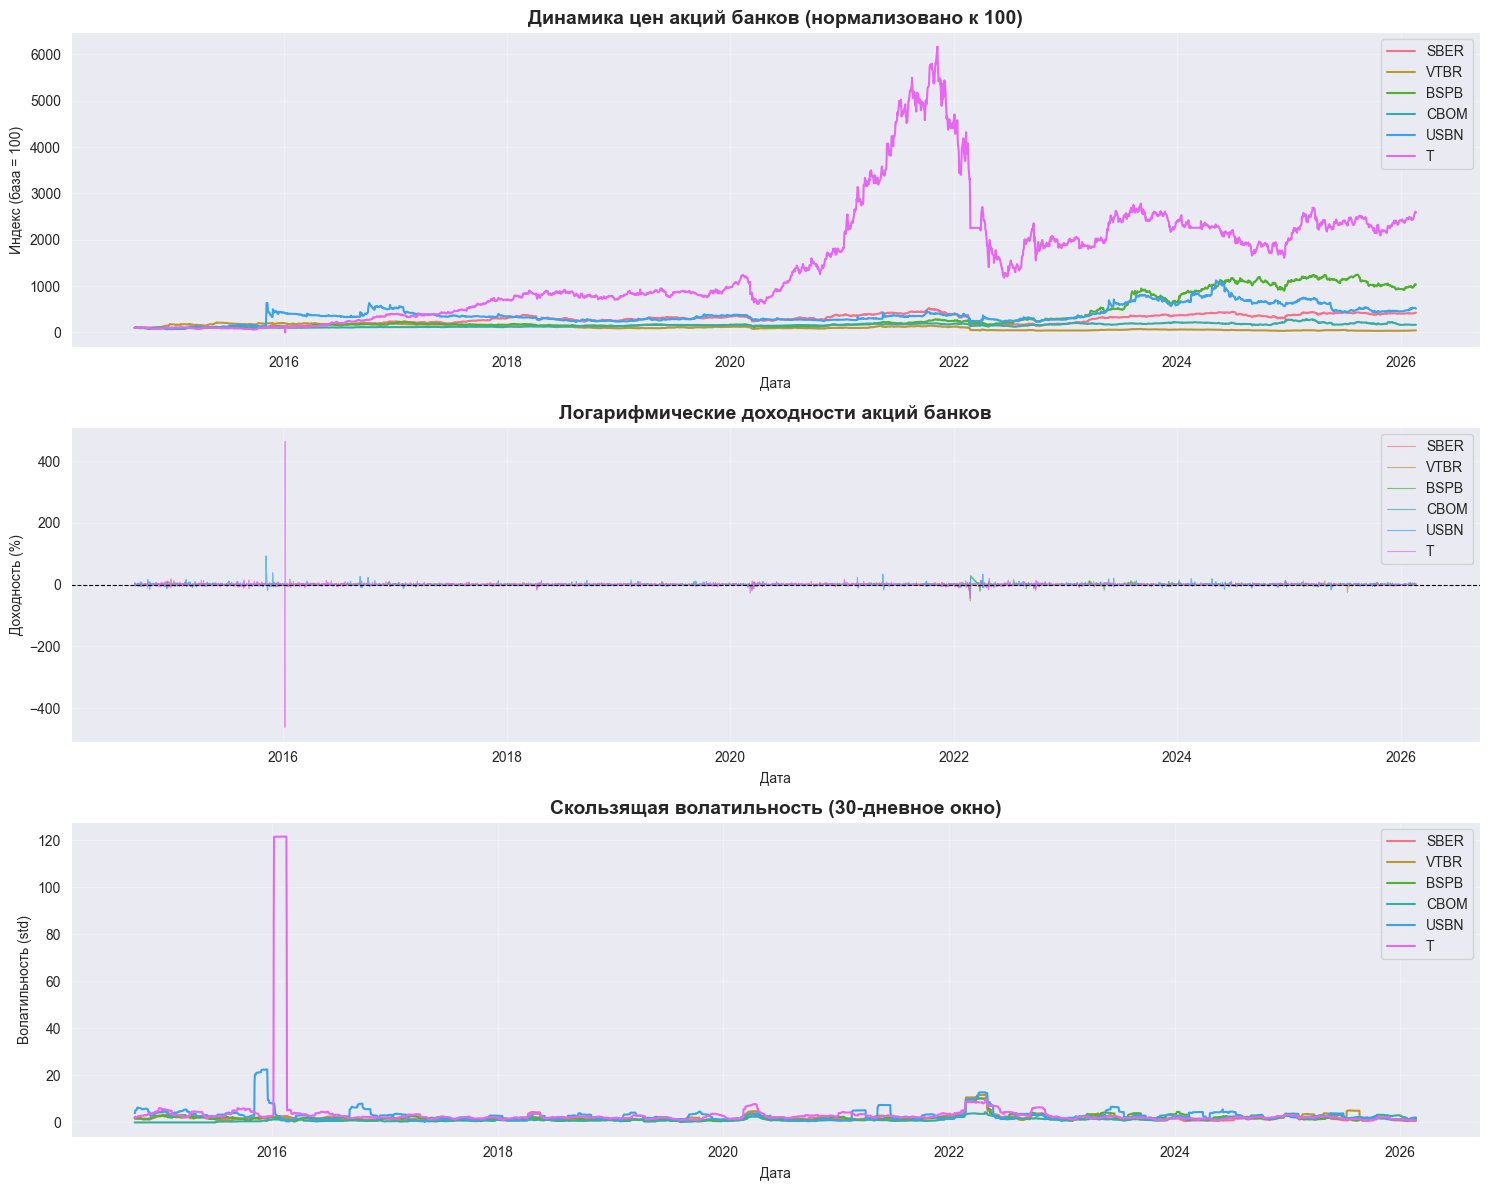

In [8]:
# Настройка стиля
sns.set_style("darkgrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Создаем фигуру с подграфиками
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# ========================================
# 1. График цен акций
# ========================================
ax1 = axes[0]
for ticker in prices.columns:
    # Нормализуем к 100 для сравнения
    normalized = (prices[ticker] / prices[ticker].iloc[0]) * 100
    ax1.plot(normalized.index.to_numpy(), normalized.to_numpy(), label=ticker, linewidth=1.5)  # Исправлено

ax1.set_title('Динамика цен акций банков (нормализовано к 100)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Индекс (база = 100)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# ========================================
# 2. График логарифмических доходностей
# ========================================
ax2 = axes[1]
for ticker in returns.columns:
    ax2.plot(returns.index.to_numpy(), returns[ticker].to_numpy(), label=ticker, linewidth=0.8, alpha=0.7)  # Исправлено

ax2.set_title('Логарифмические доходности акций банков', fontsize=14, fontweight='bold')
ax2.set_xlabel('Дата')
ax2.set_ylabel('Доходность (%)')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# ========================================
# 3. Скользящая волатильность (rolling std)
# ========================================
ax3 = axes[2]
window = 30  # 30-дневное окно

for ticker in returns.columns:
    rolling_vol = returns[ticker].rolling(window=window).std()
    ax3.plot(rolling_vol.index.to_numpy(), rolling_vol.to_numpy(), label=ticker, linewidth=1.5)  # Исправлено

ax3.set_title(f'Скользящая волатильность ({window}-дневное окно)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Дата')
ax3.set_ylabel('Волатильность (std)')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('banks_overview.png', dpi=300, bbox_inches='tight')
plt.show()

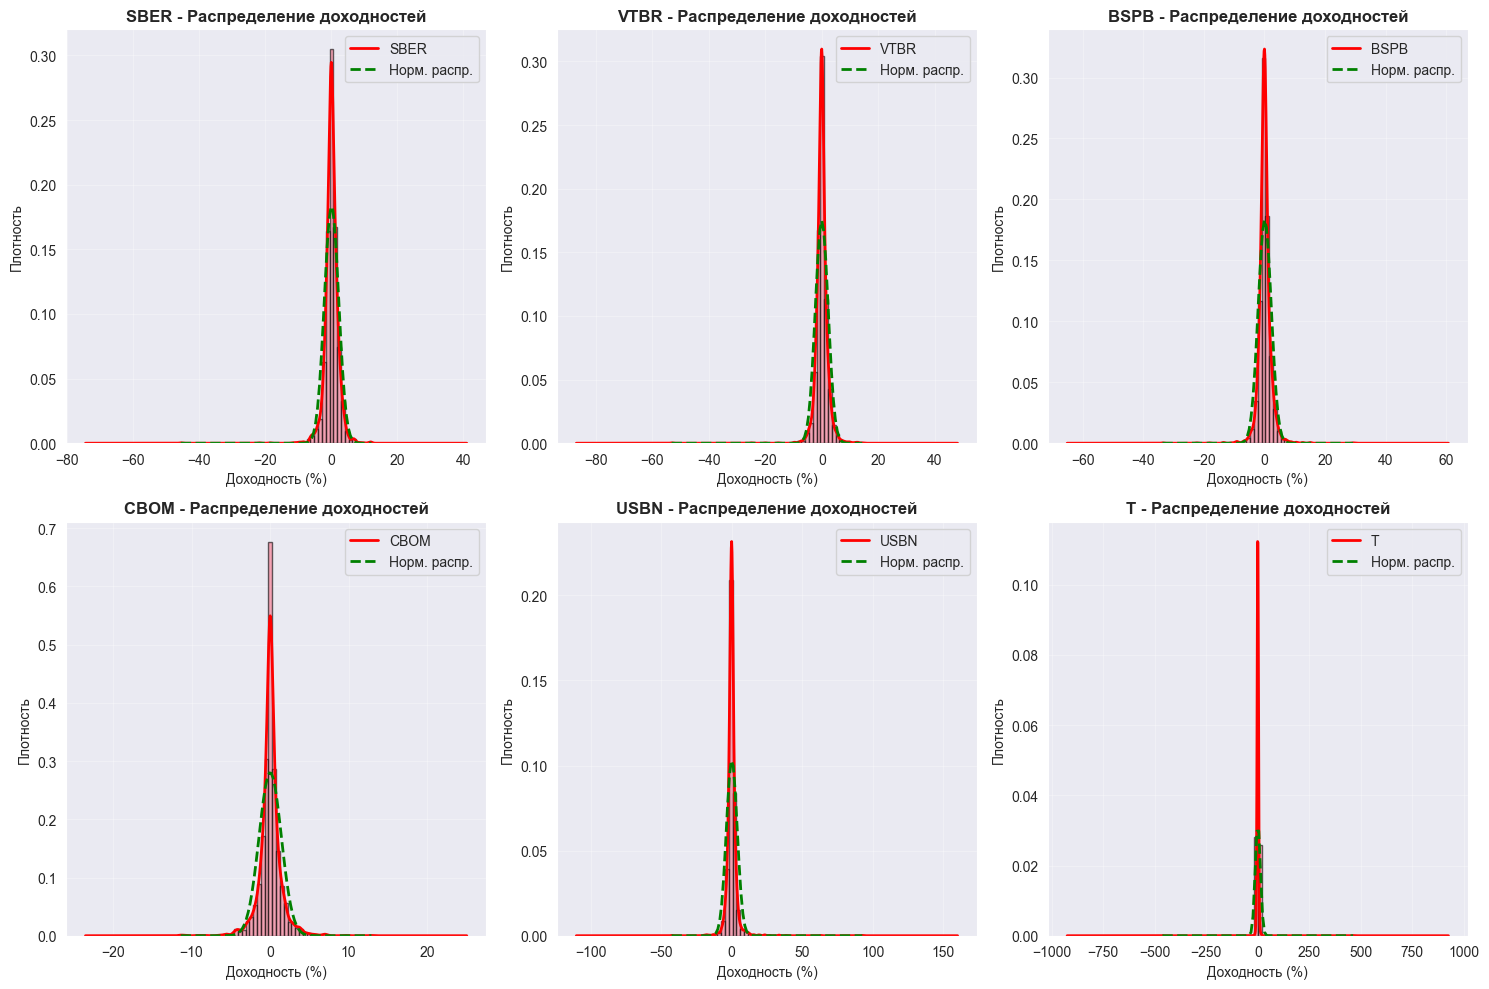

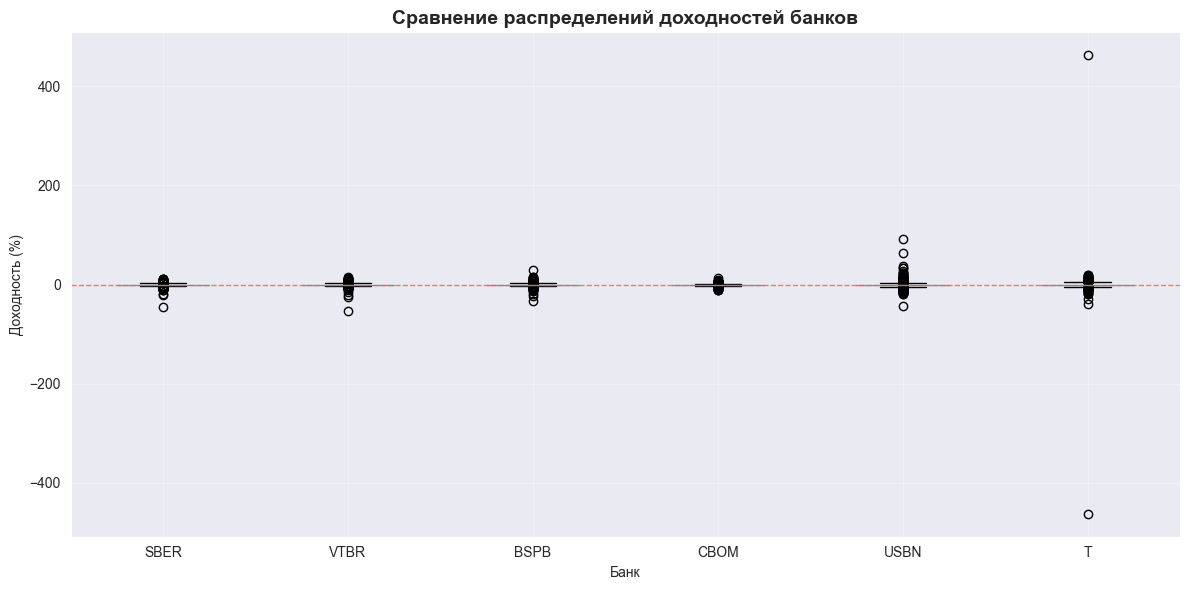

In [9]:
# ========================================
# ДОПОЛНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ
# ========================================

# Распределения доходностей
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, ticker in enumerate(returns.columns):
    ax = axes[idx]
    
    # Гистограмма с KDE
    returns[ticker].hist(bins=50, alpha=0.6, ax=ax, density=True, edgecolor='black')
    returns[ticker].plot(kind='kde', ax=ax, linewidth=2, color='red')
    
    # Добавляем нормальное распределение для сравнения
    mu, std = returns[ticker].mean(), returns[ticker].std()
    x = np.linspace(returns[ticker].min(), returns[ticker].max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, std), 'g--', linewidth=2, label='Норм. распр.')
    
    ax.set_title(f'{ticker} - Распределение доходностей', fontweight='bold')
    ax.set_xlabel('Доходность (%)')
    ax.set_ylabel('Плотность')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Удаляем лишний subplot если банков меньше 6
if len(returns.columns) < 6:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('banks_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# Box plots для сравнения волатильности
# ========================================
fig, ax = plt.subplots(figsize=(12, 6))

returns.boxplot(ax=ax, grid=False)
ax.set_title('Сравнение распределений доходностей банков', fontsize=14, fontweight='bold')
ax.set_xlabel('Банк')
ax.set_ylabel('Доходность (%)')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('banks_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

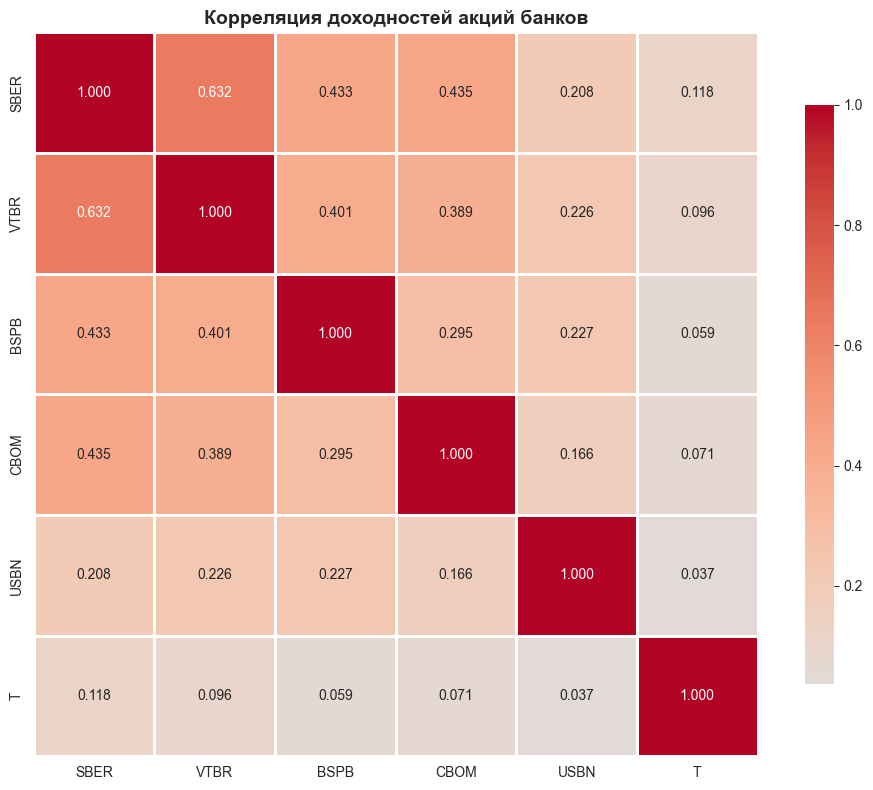

In [10]:
# ========================================
# Корреляционная матрица доходностей
# ========================================
fig, ax = plt.subplots(figsize=(10, 8))

correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, ax=ax,
            cbar_kws={"shrink": 0.8})

ax.set_title('Корреляция доходностей акций банков', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('banks_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# ========================================
# Базовая статистика в табличном виде
# ========================================
print("\n" + "="*80)
print("ОПИСАТЕЛЬНАЯ СТАТИСТИКА ДОХОДНОСТЕЙ")
print("="*80)
print(returns.describe().round(4))

print("\n" + "="*80)
print("КОРРЕЛЯЦИОННАЯ МАТРИЦА")
print("="*80)
print(correlation_matrix.round(3))


ОПИСАТЕЛЬНАЯ СТАТИСТИКА ДОХОДНОСТЕЙ
            SBER       VTBR       BSPB       CBOM       USBN          T
count  2923.0000  2923.0000  2923.0000  2923.0000  2923.0000  2923.0000
mean      0.0496    -0.0263     0.0800     0.0172     0.0561     0.1114
std       2.1728     2.2812     2.1775     1.4222     3.8605    12.4745
min     -45.5918   -53.1974   -33.6472   -11.3668   -42.5668  -462.5932
25%      -0.8342    -0.9188    -0.7963    -0.4830    -1.1429    -1.2011
50%       0.0261    -0.0214     0.0000     0.0000     0.0000     0.0000
75%       1.0218     0.8212     0.8382     0.5047     0.9271     1.4014
max      12.1320    14.3334    29.2371    12.9082    92.5153   462.7366

КОРРЕЛЯЦИОННАЯ МАТРИЦА
       SBER   VTBR   BSPB   CBOM   USBN      T
SBER  1.000  0.632  0.433  0.435  0.208  0.118
VTBR  0.632  1.000  0.401  0.389  0.226  0.096
BSPB  0.433  0.401  1.000  0.295  0.227  0.059
CBOM  0.435  0.389  0.295  1.000  0.166  0.071
USBN  0.208  0.226  0.227  0.166  1.000  0.037
T     0.1

## Шаг 3: Тесты на стационарность и ARCH-эффекты

In [12]:
# ========================================
# 1. ТЕСТ НА СТАЦИОНАРНОСТЬ (ADF и KPSS)
# ========================================

def test_stationarity(series, name):
    """
    Проводит тесты на стационарность:
    - ADF (Augmented Dickey-Fuller): H0 = ряд нестационарен
    - KPSS: H0 = ряд стационарен
    """
    print(f"\n{'='*60}")
    print(f"ТЕСТЫ НА СТАЦИОНАРНОСТЬ: {name}")
    print(f"{'='*60}")
    
    # ADF тест
    adf_result = adfuller(series.dropna(), autolag='AIC')
    print("\n1. ADF тест (H0: ряд нестационарен)")
    print(f"   ADF статистика: {adf_result[0]:.6f}")
    print(f"   p-value: {adf_result[1]:.6f}")
    print(f"   Критические значения:")
    for key, value in adf_result[4].items():
        print(f"      {key}: {value:.3f}")
    
    if adf_result[1] < 0.05:
        print(f"   ✓ Вывод: Ряд СТАЦИОНАРЕН (p-value < 0.05)")
    else:
        print(f"   ✗ Вывод: Ряд НЕСТАЦИОНАРЕН (p-value >= 0.05)")
    
    # KPSS тест
    kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
    print("\n2. KPSS тест (H0: ряд стационарен)")
    print(f"   KPSS статистика: {kpss_result[0]:.6f}")
    print(f"   p-value: {kpss_result[1]:.6f}")
    print(f"   Критические значения:")
    for key, value in kpss_result[3].items():
        print(f"      {key}: {value:.3f}")
    
    if kpss_result[1] > 0.05:
        print(f"   ✓ Вывод: Ряд СТАЦИОНАРЕН (p-value > 0.05)")
    else:
        print(f"   ✗ Вывод: Ряд НЕСТАЦИОНАРЕН (p-value <= 0.05)")
    
    return {
        'ADF_statistic': adf_result[0],
        'ADF_pvalue': adf_result[1],
        'KPSS_statistic': kpss_result[0],
        'KPSS_pvalue': kpss_result[1]
    }

# ========================================
# 2. ТЕСТ НА ARCH-ЭФФЕКТЫ
# ========================================

def test_arch_effects(series, name, lags=10):
    """
    Проводит тесты на наличие ARCH-эффектов:
    - Ljung-Box тест для квадратов остатков
    - ARCH LM тест
    """
    print(f"\n{'='*60}")
    print(f"ТЕСТЫ НА ARCH-ЭФФЕКТЫ: {name}")
    print(f"{'='*60}")
    
    series_clean = series.dropna()
    
    # Ljung-Box тест для исходного ряда
    lb_result = acorr_ljungbox(series_clean, lags=lags, return_df=True)
    print(f"\n1. Ljung-Box тест для доходностей (лаги 1-{lags})")
    print(f"   Минимальный p-value: {lb_result['lb_pvalue'].min():.6f}")
    if lb_result['lb_pvalue'].min() < 0.05:
        print(f"   ✓ Есть автокорреляция в доходностях")
    else:
        print(f"   ✗ Нет автокорреляции в доходностях")
    
    # Ljung-Box тест для квадратов (проверка на ARCH)
    lb_squared = acorr_ljungbox(series_clean**2, lags=lags, return_df=True)
    print(f"\n2. Ljung-Box тест для квадратов доходностей (лаги 1-{lags})")
    print(f"   Минимальный p-value: {lb_squared['lb_pvalue'].min():.6f}")
    if lb_squared['lb_pvalue'].min() < 0.05:
        print(f"   ✓ Есть ARCH-эффекты (кластеризация волатильности)")
    else:
        print(f"   ✗ Нет ARCH-эффектов")
    
    # ARCH LM тест
    arch_lm = het_arch(series_clean, nlags=lags)
    print(f"\n3. ARCH LM тест (H0: нет ARCH-эффектов)")
    print(f"   LM статистика: {arch_lm[0]:.6f}")
    print(f"   p-value: {arch_lm[1]:.6f}")
    print(f"   F-статистика: {arch_lm[2]:.6f}")
    print(f"   F p-value: {arch_lm[3]:.6f}")
    
    if arch_lm[1] < 0.05:
        print(f"   ✓ Есть ARCH-эффекты (p-value < 0.05)")
        print(f"   → GARCH модель ЦЕЛЕСООБРАЗНА")
    else:
        print(f"   ✗ Нет ARCH-эффектов (p-value >= 0.05)")
        print(f"   → GARCH модель может быть НЕ нужна")
    
    return {
        'LB_returns_pvalue': lb_result['lb_pvalue'].min(),
        'LB_squared_pvalue': lb_squared['lb_pvalue'].min(),
        'ARCH_LM_statistic': arch_lm[0],
        'ARCH_LM_pvalue': arch_lm[1]
    }




████████████████████████████████████████████████████████████████████████████████
АНАЛИЗ: SBER
████████████████████████████████████████████████████████████████████████████████

ТЕСТЫ НА СТАЦИОНАРНОСТЬ: SBER

1. ADF тест (H0: ряд нестационарен)
   ADF статистика: -18.979878
   p-value: 0.000000
   Критические значения:
      1%: -3.433
      5%: -2.863
      10%: -2.567
   ✓ Вывод: Ряд СТАЦИОНАРЕН (p-value < 0.05)

2. KPSS тест (H0: ряд стационарен)
   KPSS статистика: 0.102644
   p-value: 0.100000
   Критические значения:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✓ Вывод: Ряд СТАЦИОНАРЕН (p-value > 0.05)

ТЕСТЫ НА ARCH-ЭФФЕКТЫ: SBER

1. Ljung-Box тест для доходностей (лаги 1-10)
   Минимальный p-value: 0.026387
   ✓ Есть автокорреляция в доходностях

2. Ljung-Box тест для квадратов доходностей (лаги 1-10)
   Минимальный p-value: 0.000000
   ✓ Есть ARCH-эффекты (кластеризация волатильности)

3. ARCH LM тест (H0: нет ARCH-эффектов)
   LM статистика: 151.703704

C:\Users\79600\AppData\Local\Temp\ipykernel_25200\1734819736.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\79600\AppData\Local\Temp\ipykernel_25200\1734819736.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\79600\AppData\Local\Temp\ipykernel_25200\1734819736.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags='auto')



1. ADF тест (H0: ряд нестационарен)
   ADF статистика: -20.968724
   p-value: 0.000000
   Критические значения:
      1%: -3.433
      5%: -2.863
      10%: -2.567
   ✓ Вывод: Ряд СТАЦИОНАРЕН (p-value < 0.05)

2. KPSS тест (H0: ряд стационарен)
   KPSS статистика: 0.159193
   p-value: 0.100000
   Критические значения:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✓ Вывод: Ряд СТАЦИОНАРЕН (p-value > 0.05)

ТЕСТЫ НА ARCH-ЭФФЕКТЫ: BSPB

1. Ljung-Box тест для доходностей (лаги 1-10)
   Минимальный p-value: 0.002437
   ✓ Есть автокорреляция в доходностях

2. Ljung-Box тест для квадратов доходностей (лаги 1-10)
   Минимальный p-value: 0.000000
   ✓ Есть ARCH-эффекты (кластеризация волатильности)

3. ARCH LM тест (H0: нет ARCH-эффектов)
   LM статистика: 704.437479
   p-value: 0.000000
   F-статистика: 92.561453
   F p-value: 0.000000
   ✓ Есть ARCH-эффекты (p-value < 0.05)
   → GARCH модель ЦЕЛЕСООБРАЗНА

██████████████████████████████████████████████████████████████

C:\Users\79600\AppData\Local\Temp\ipykernel_25200\1734819736.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\79600\AppData\Local\Temp\ipykernel_25200\1734819736.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\79600\AppData\Local\Temp\ipykernel_25200\1734819736.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags='auto')


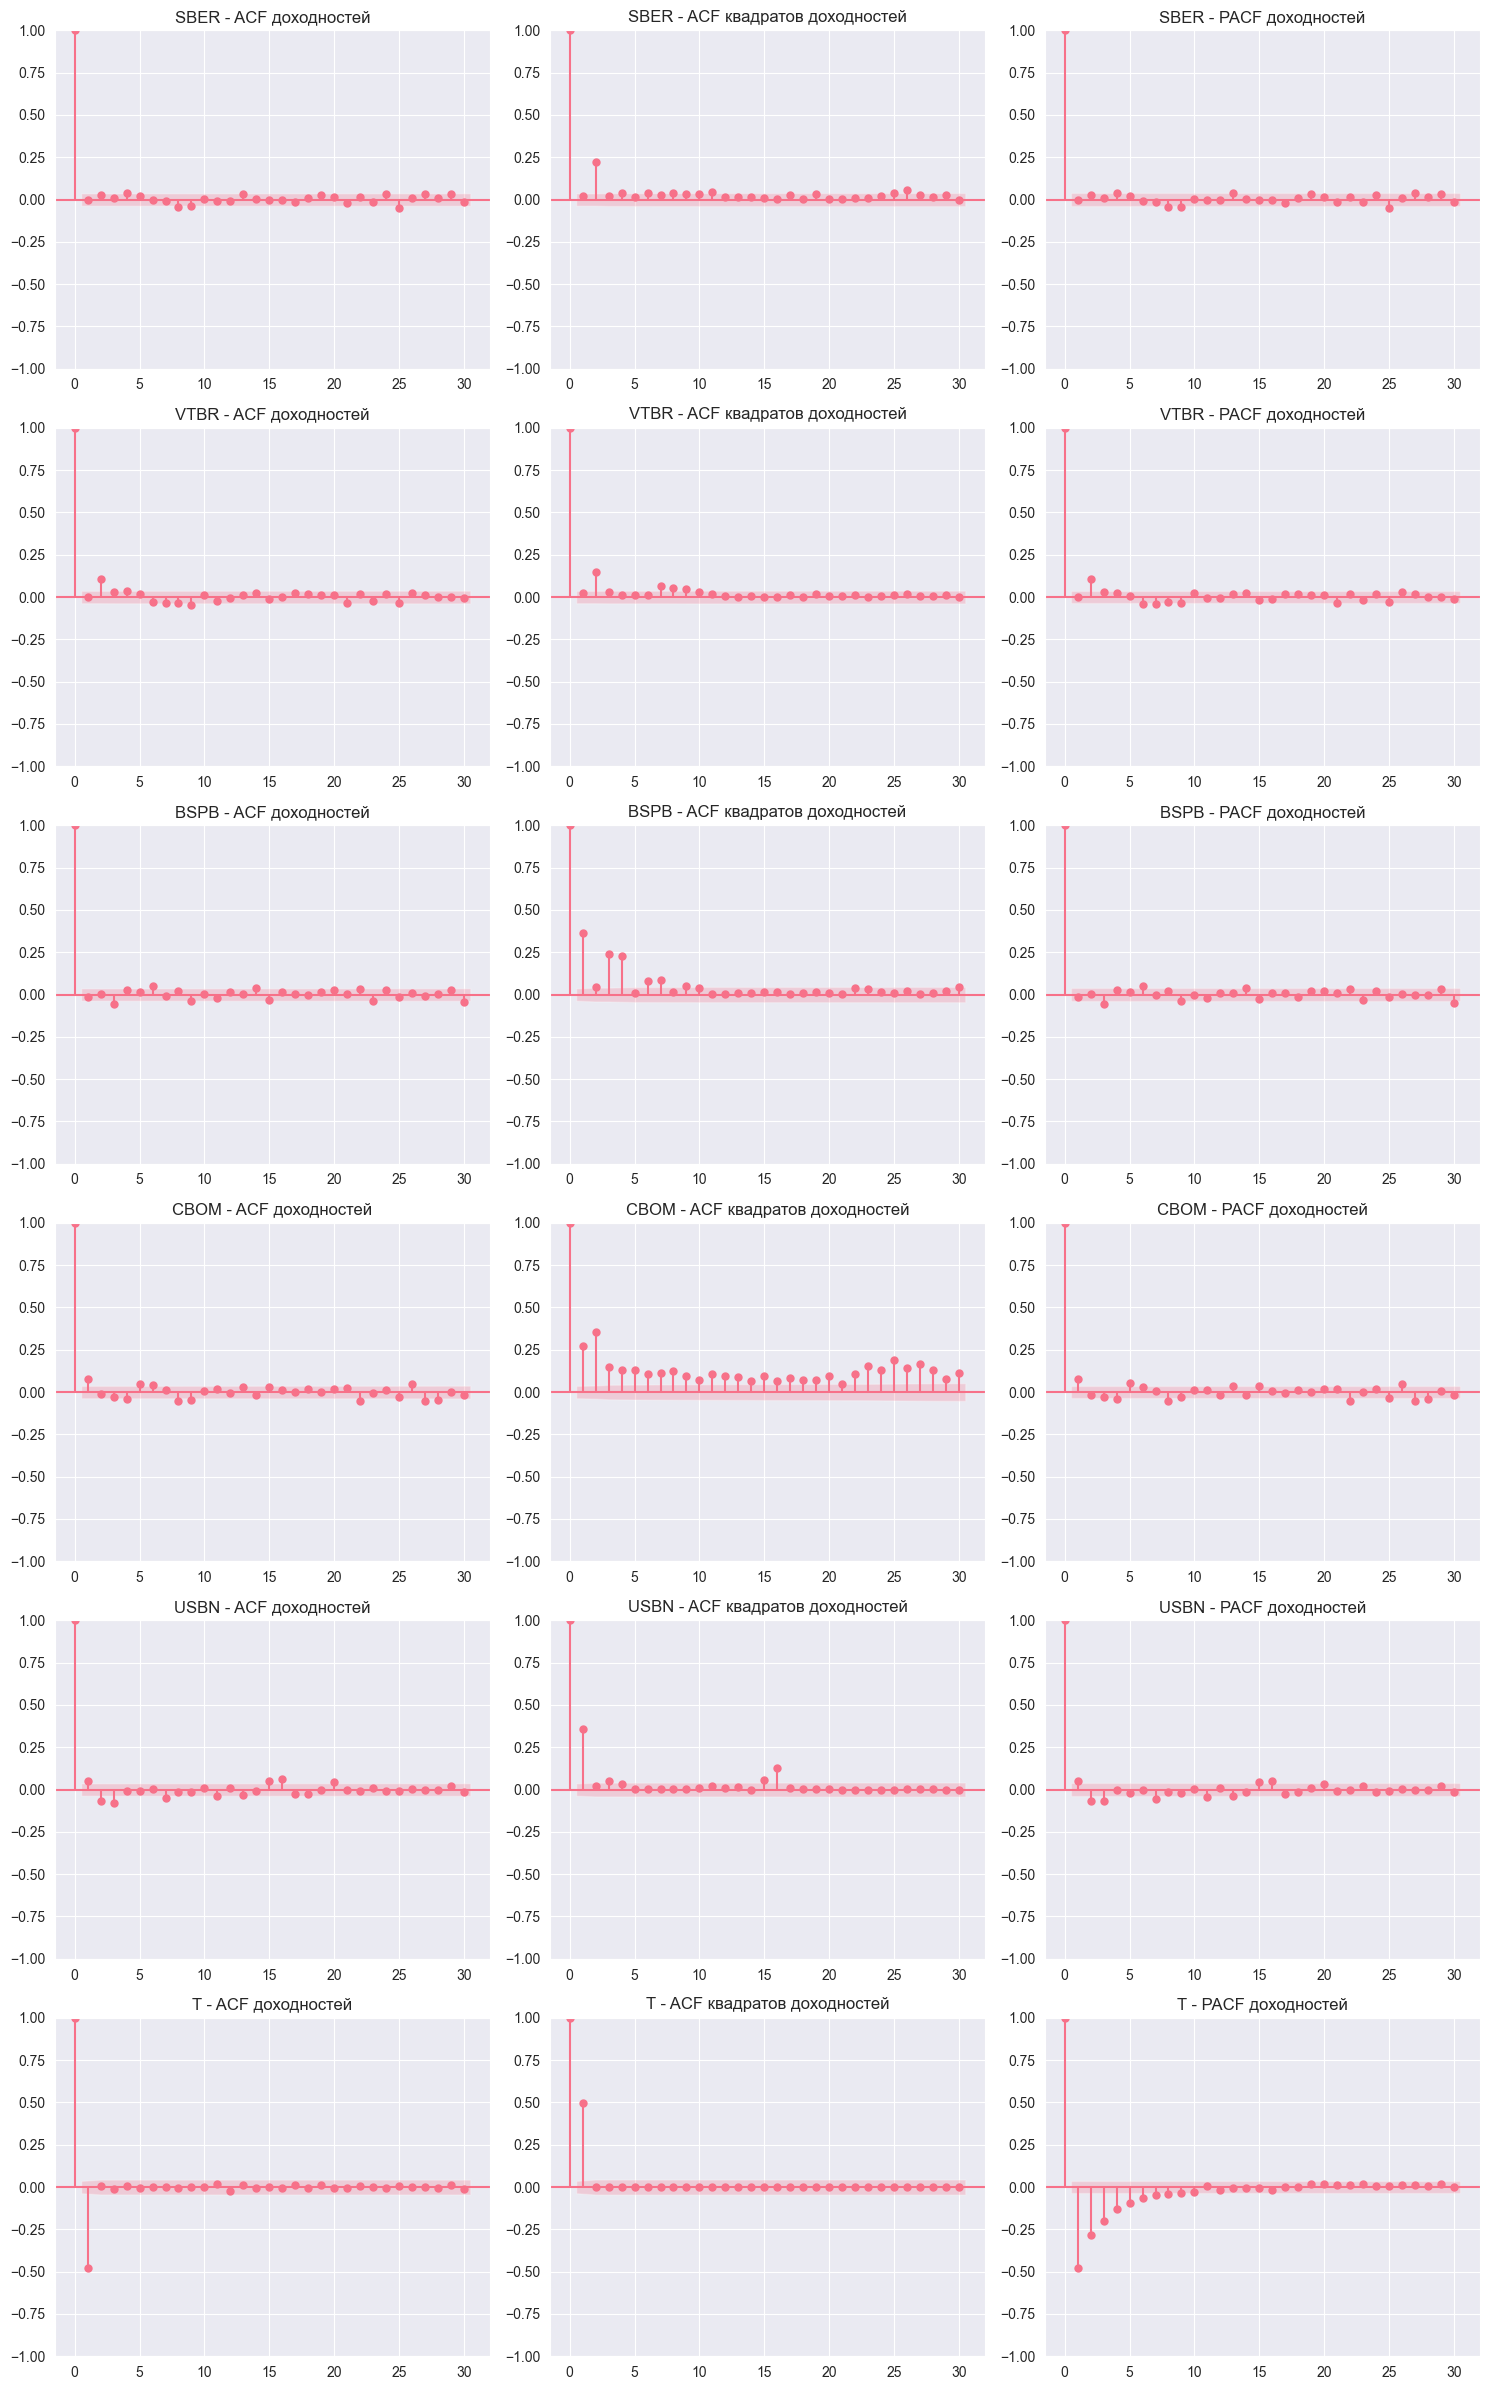

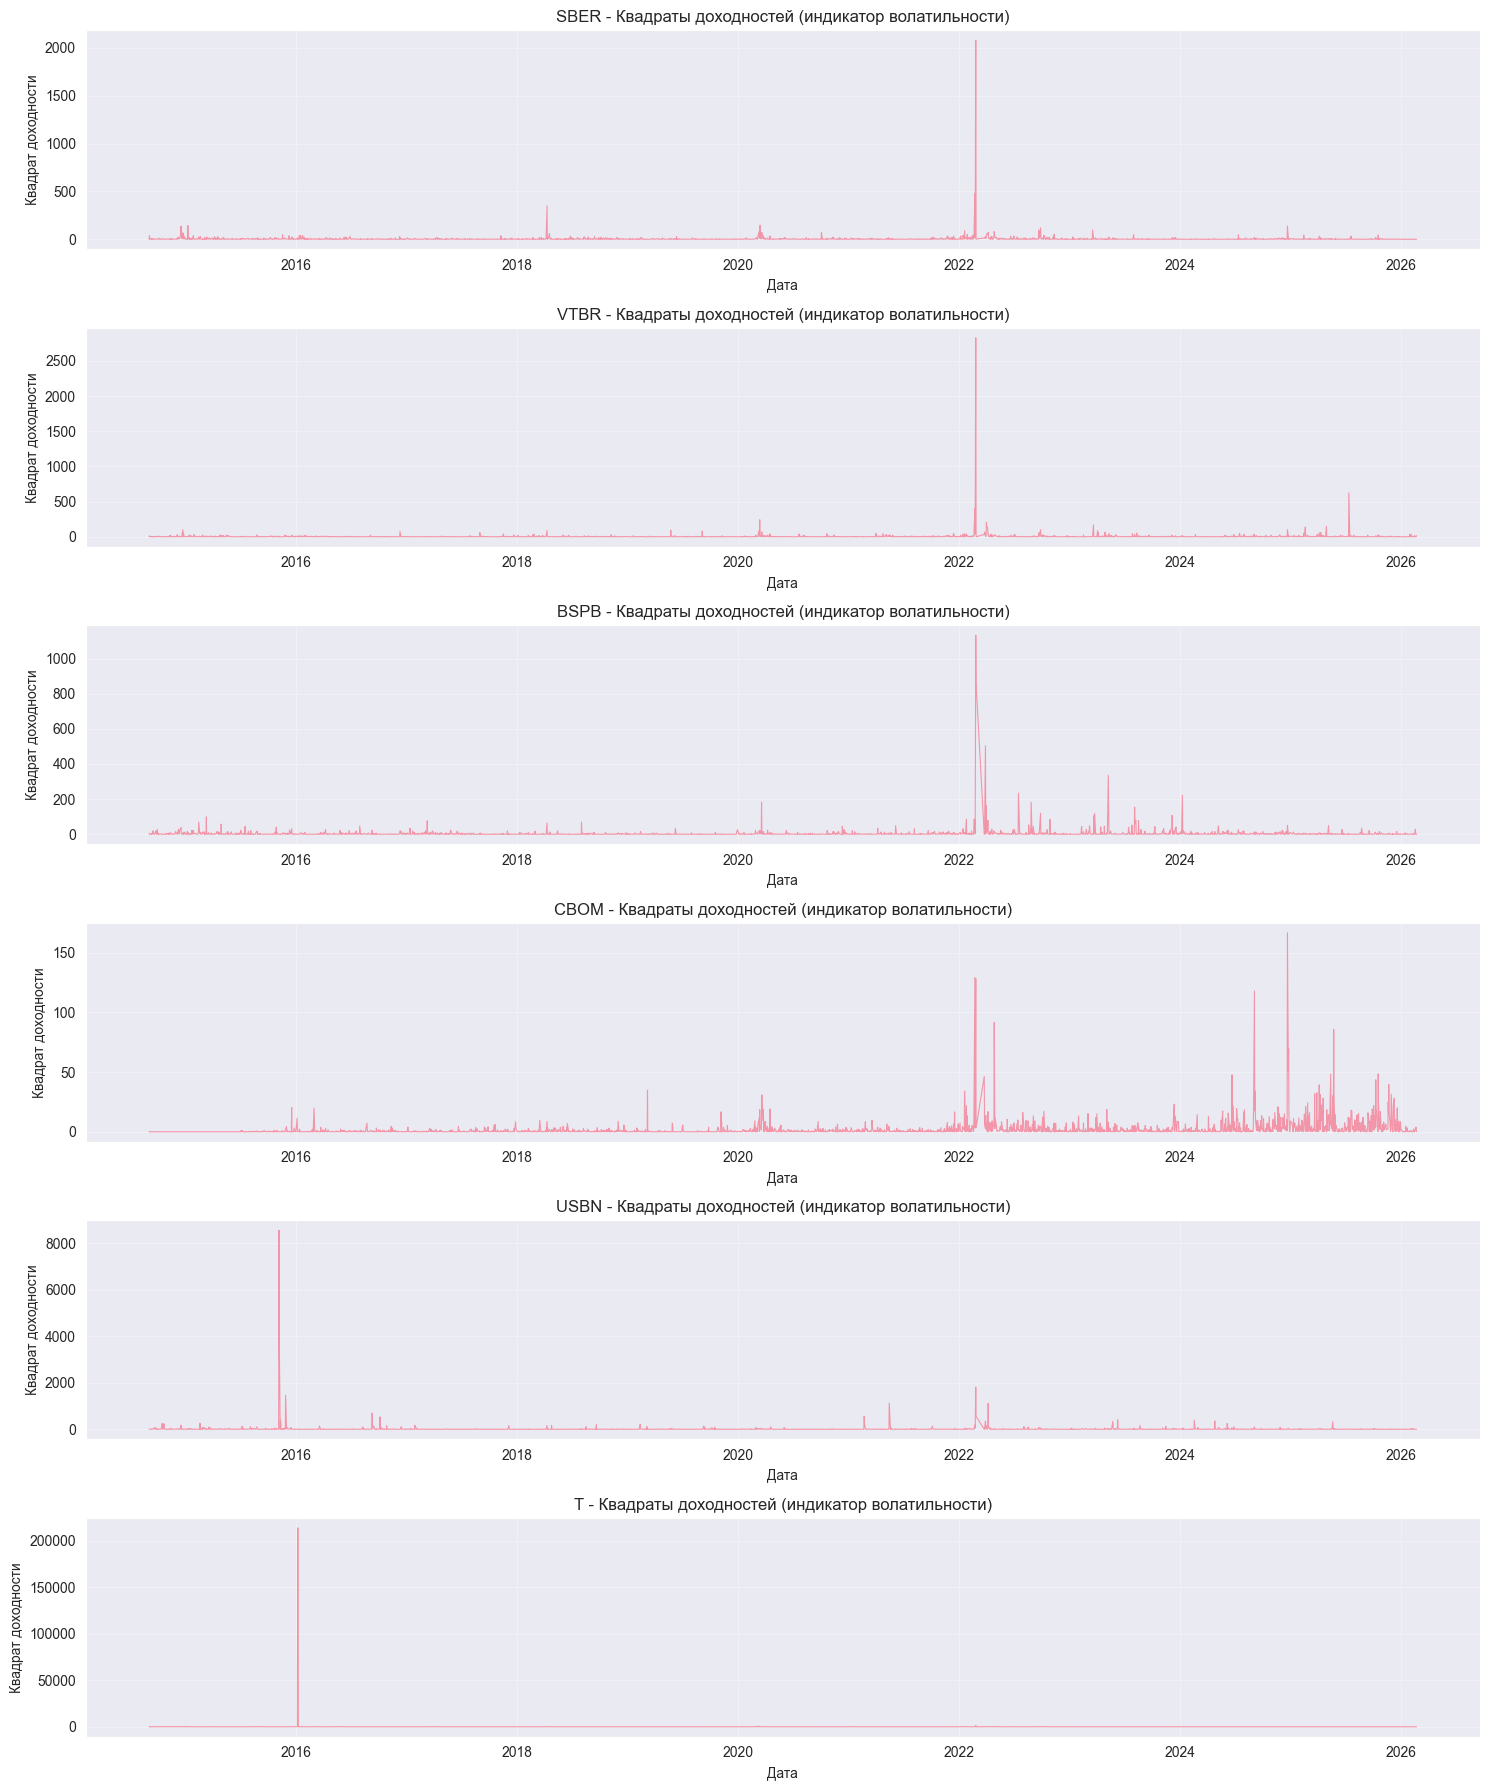


ВЫВОДЫ

SBER:
  ✓ Ряд доходностей стационарен (можно применять ARMA/GARCH)
  ✓ Обнаружены ARCH-эффекты (GARCH модель целесообразна)

VTBR:
  ✓ Ряд доходностей стационарен (можно применять ARMA/GARCH)
  ✓ Обнаружены ARCH-эффекты (GARCH модель целесообразна)

BSPB:
  ✓ Ряд доходностей стационарен (можно применять ARMA/GARCH)
  ✓ Обнаружены ARCH-эффекты (GARCH модель целесообразна)

CBOM:
  ✓ Ряд доходностей стационарен (можно применять ARMA/GARCH)
  ✓ Обнаружены ARCH-эффекты (GARCH модель целесообразна)

USBN:
  ✓ Ряд доходностей стационарен (можно применять ARMA/GARCH)
  ✓ Обнаружены ARCH-эффекты (GARCH модель целесообразна)

T:
  ✓ Ряд доходностей стационарен (можно применять ARMA/GARCH)
  ✓ Обнаружены ARCH-эффекты (GARCH модель целесообразна)

✓ Результаты сохранены в 'test_results.csv'


In [13]:
# ========================================
# 3. ПРИМЕНЯЕМ ТЕСТЫ КО ВСЕМ БАНКАМ
# ========================================

stationarity_results = {}
arch_results = {}

for ticker in returns.columns:
    print("\n" + "█"*80)
    print(f"АНАЛИЗ: {ticker}")
    print("█"*80)
    
    # Тесты на стационарность
    stat_res = test_stationarity(returns[ticker], ticker)
    stationarity_results[ticker] = stat_res
    
    # Тесты на ARCH-эффекты
    arch_res = test_arch_effects(returns[ticker], ticker, lags=10)
    arch_results[ticker] = arch_res

# ========================================
# 4. СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
# ========================================

print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ТЕСТОВ")
print("="*80)

# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Банк': returns.columns,
    'ADF p-value': [stationarity_results[t]['ADF_pvalue'] for t in returns.columns],
    'KPSS p-value': [stationarity_results[t]['KPSS_pvalue'] for t in returns.columns],
    'LB (squared) p-value': [arch_results[t]['LB_squared_pvalue'] for t in returns.columns],
    'ARCH LM p-value': [arch_results[t]['ARCH_LM_pvalue'] for t in returns.columns]
})

results_df['Стационарен (ADF)'] = results_df['ADF p-value'] < 0.05
results_df['Стационарен (KPSS)'] = results_df['KPSS p-value'] > 0.05
results_df['ARCH-эффекты'] = results_df['ARCH LM p-value'] < 0.05

print("\n", results_df.to_string(index=False))

# ========================================
# 5. ВИЗУАЛИЗАЦИЯ ACF/PACF
# ========================================

fig, axes = plt.subplots(len(returns.columns), 3, figsize=(15, 4*len(returns.columns)))

if len(returns.columns) == 1:
    axes = axes.reshape(1, -1)

for idx, ticker in enumerate(returns.columns):
    series = returns[ticker].dropna()
    
    # ACF для доходностей
    plot_acf(series, lags=30, ax=axes[idx, 0], alpha=0.05)
    axes[idx, 0].set_title(f'{ticker} - ACF доходностей')
    
    # ACF для квадратов доходностей
    plot_acf(series**2, lags=30, ax=axes[idx, 1], alpha=0.05)
    axes[idx, 1].set_title(f'{ticker} - ACF квадратов доходностей')
    
    # PACF для доходностей
    plot_pacf(series, lags=30, ax=axes[idx, 2], alpha=0.05, method='ywm')
    axes[idx, 2].set_title(f'{ticker} - PACF доходностей')

plt.tight_layout()
plt.savefig('banks_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 6. ВИЗУАЛИЗАЦИЯ КВАДРАТОВ ДОХОДНОСТЕЙ
# ========================================

fig, axes = plt.subplots(len(returns.columns), 1, figsize=(15, 3*len(returns.columns)))

if len(returns.columns) == 1:
    axes = [axes]

for idx, ticker in enumerate(returns.columns):
    series = returns[ticker].dropna()
    axes[idx].plot(series.index.to_numpy(), (series**2).to_numpy(), linewidth=0.8, alpha=0.7)
    axes[idx].set_title(f'{ticker} - Квадраты доходностей (индикатор волатильности)')
    axes[idx].set_xlabel('Дата')
    axes[idx].set_ylabel('Квадрат доходности')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('banks_squared_returns.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 7. ВЫВОДЫ
# ========================================

print("\n" + "="*80)
print("ВЫВОДЫ")
print("="*80)

for ticker in returns.columns:
    print(f"\n{ticker}:")
    
    if results_df[results_df['Банк'] == ticker]['Стационарен (ADF)'].values[0]:
        print("  ✓ Ряд доходностей стационарен (можно применять ARMA/GARCH)")
    else:
        print("  ✗ Ряд доходностей нестационарен (требуется дополнительная обработка)")
    
    if results_df[results_df['Банк'] == ticker]['ARCH-эффекты'].values[0]:
        print("  ✓ Обнаружены ARCH-эффекты (GARCH модель целесообразна)")
    else:
        print("  ⚠ ARCH-эффекты не обнаружены (GARCH может быть избыточен)")

# Сохраняем результаты
results_df.to_csv('test_results.csv', index=False)
print("\n✓ Результаты сохранены в 'test_results.csv'")

ПОСТРОЕНИЕ GARCH-МОДЕЛЕЙ ДЛЯ ВСЕХ БАНКОВ

████████████████████████████████████████████████████████████████████████████████
БАНК: SBER
████████████████████████████████████████████████████████████████████████████████
Подбор модели для SBER...
Тестируется 8 комбинаций...

✓ Успешно построено 8 моделей

Топ-5 моделей по AIC:
   p  q       dist           AIC           BIC
1  1  1  studentst  11248.201908  11278.103737
3  1  2  studentst  11249.358159  11285.240354
5  2  1  studentst  11250.201908  11286.084103
7  2  2  studentst  11251.191148  11293.053709
0  1  1     normal  11680.683898  11704.605361

АНАЛИЗ МОДЕЛИ: SBER

1. ПАРАМЕТРЫ МОДЕЛИ:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         SBER   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5619.10
Distribution

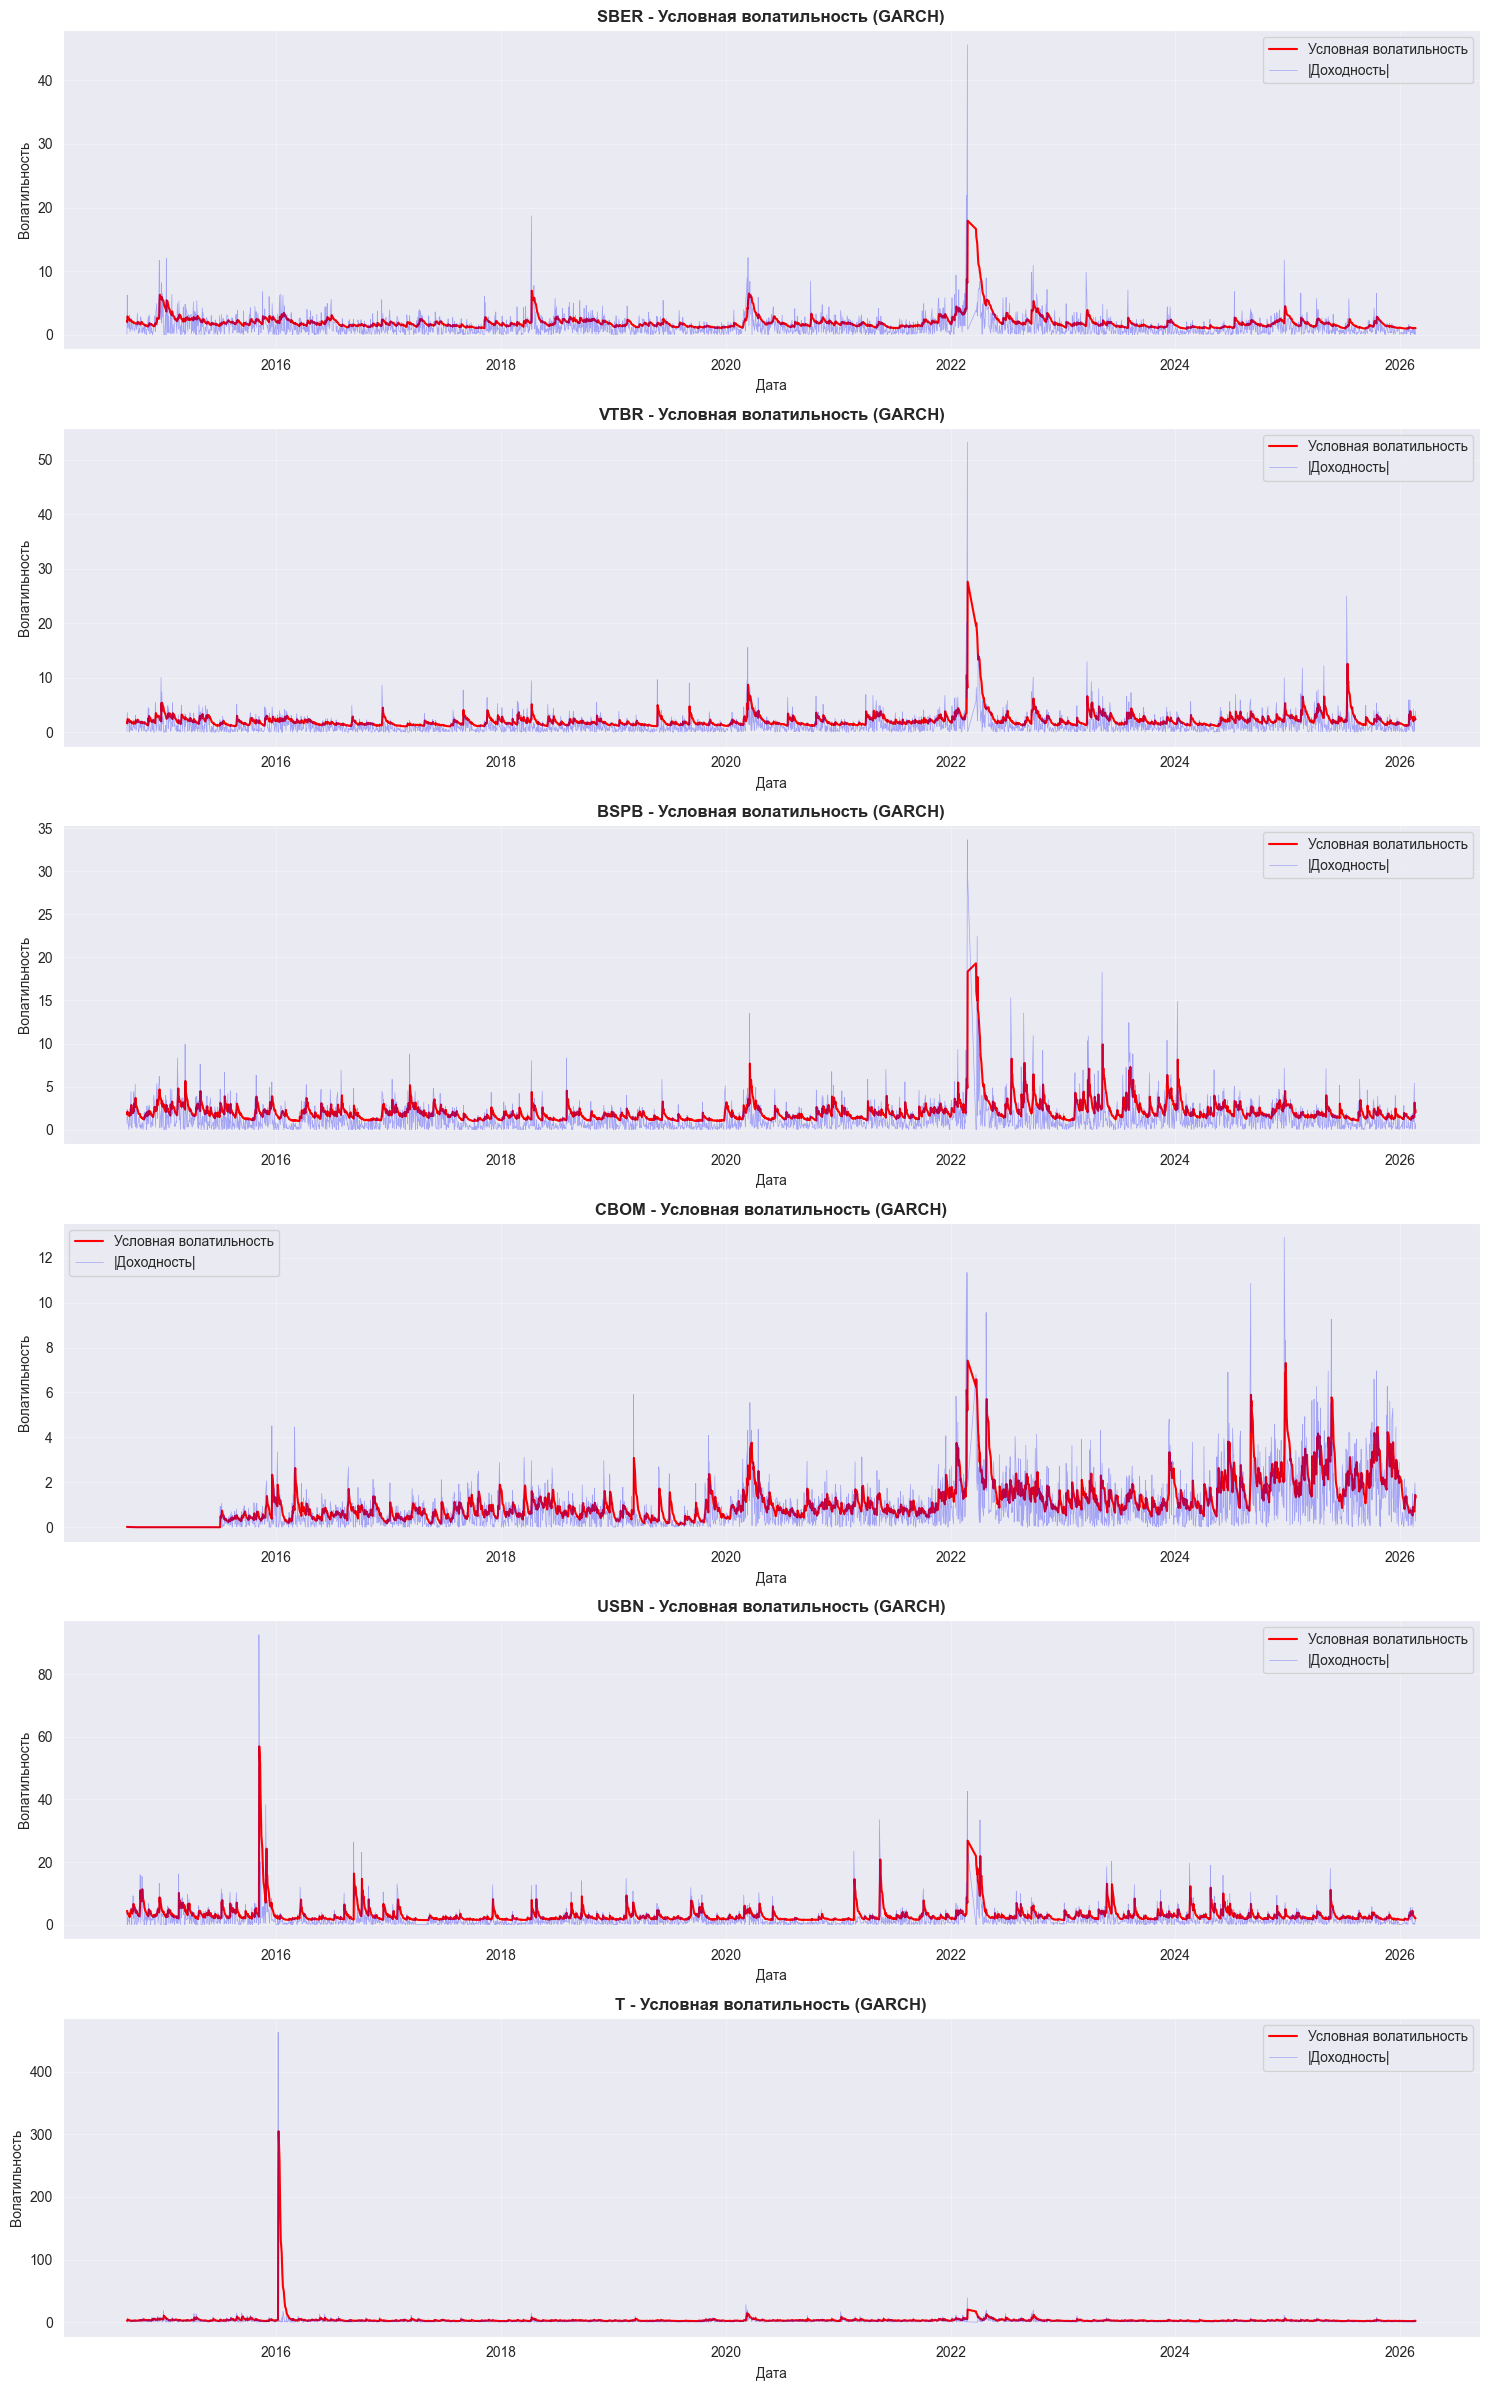

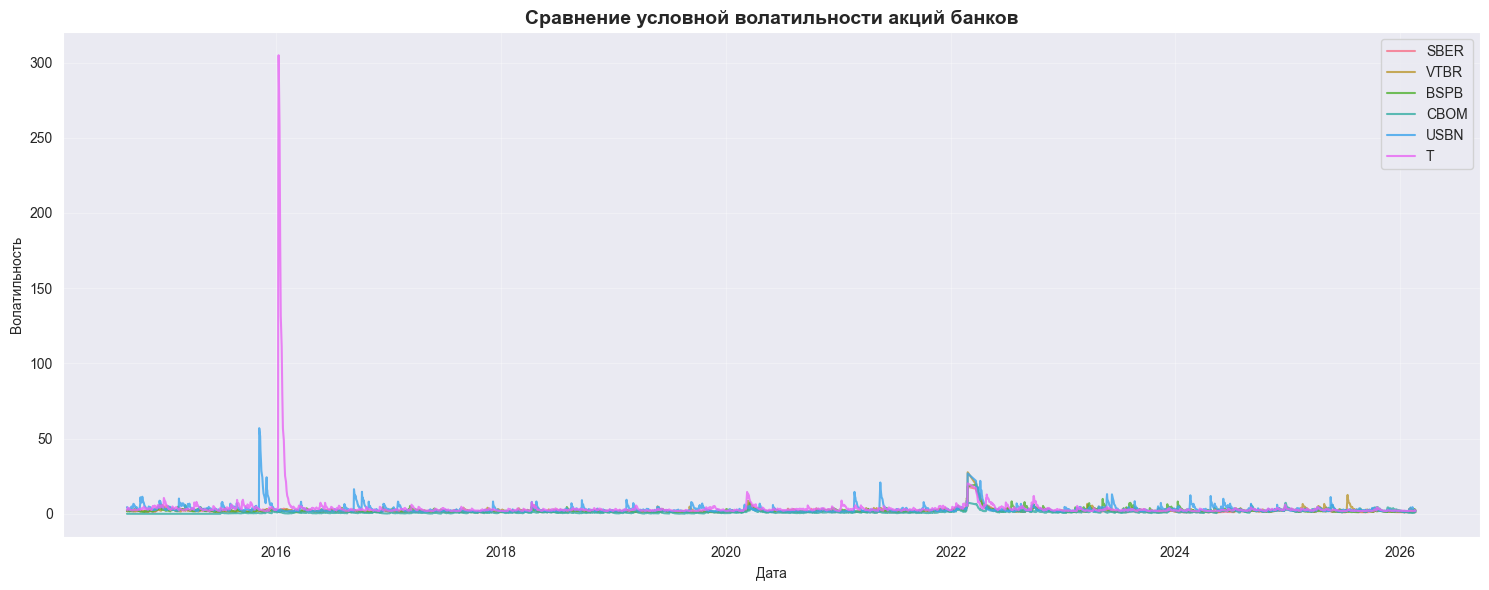


СТАТИСТИКА ВОЛАТИЛЬНОСТИ

       Средняя  Медиана      Std     Мин      Макс      CV
T      3.7165   2.6260  11.2663  1.7032  304.8474  3.0314
USBN   3.0507   2.2959   2.7974  1.4839   56.9219  0.9170
VTBR   2.1227   1.8069   1.3252  1.0700   27.6236  0.6243
BSPB   2.0471   1.7695   1.2140  0.9973   19.3118  0.5930
SBER   1.9306   1.6979   1.1052  0.9344   17.9329  0.5725
CBOM   1.0914   0.8524   0.9103  0.0002    7.4180  0.8341

ТЕКУЩАЯ ВОЛАТИЛЬНОСТЬ (ПОСЛЕДНИЕ ЗНАЧЕНИЯ)

        Текущая Средняя (1 мес) Средняя (3 мес) Общая средняя        Дата
VTBR   2.39074        2.374617        1.801769      2.122667  2026-02-20
T     2.079623        1.936029        1.998846      3.716493  2026-02-20
USBN  2.054558        2.771396         2.16122      3.050725  2026-02-20
BSPB  2.013782        1.579533        1.557636      2.047059  2026-02-20
CBOM  1.320906        0.836913        1.792755      1.091358  2026-02-20
SBER  1.027072        1.064614        1.108599      1.930606  2026-02-20


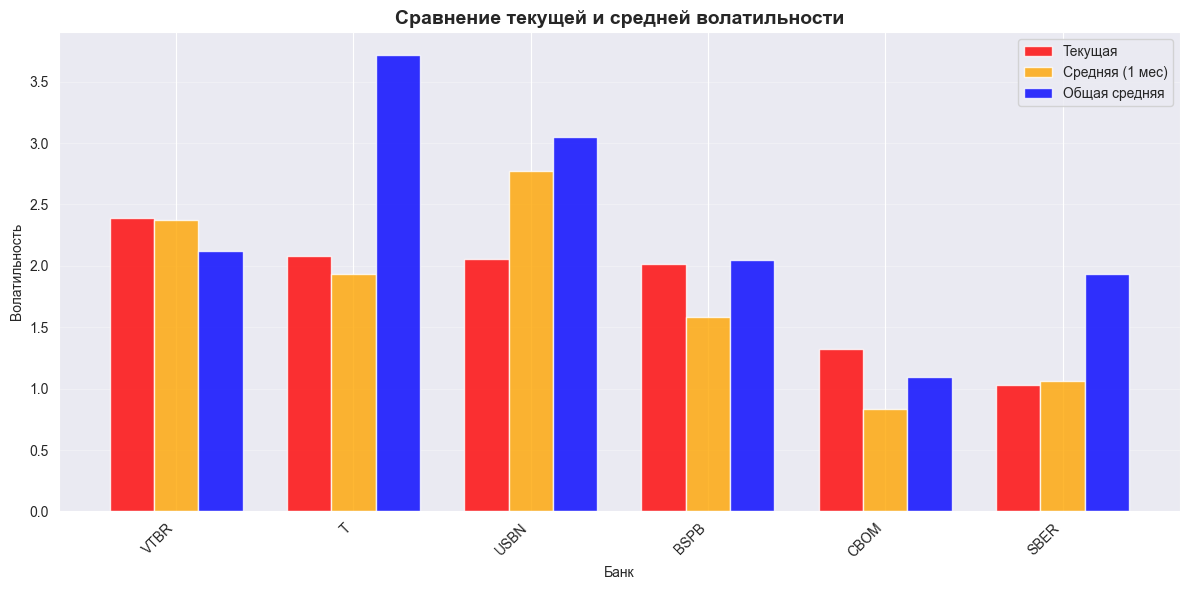


✓ Текущая волатильность сохранена в 'current_volatility.csv'

ПРОГНОЗ ВОЛАТИЛЬНОСТИ НА 1 ШАГ ВПЕРЕД

       Прогноз волатильности  Текущая волатильность  Изменение (%)
VTBR                 2.8956                 2.3907        21.1163
T                    1.9810                 2.0796        -4.7439
BSPB                 1.9620                 2.0138        -2.5703
USBN                 1.9399                 2.0546        -5.5817
CBOM                 1.1562                 1.3209       -12.4662
SBER                 1.0060                 1.0271        -2.0475


c:\users\79600\appdata\local\programs\python\python38\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\users\79600\appdata\local\programs\python\python38\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\users\79600\appdata\local\programs\python\python38\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

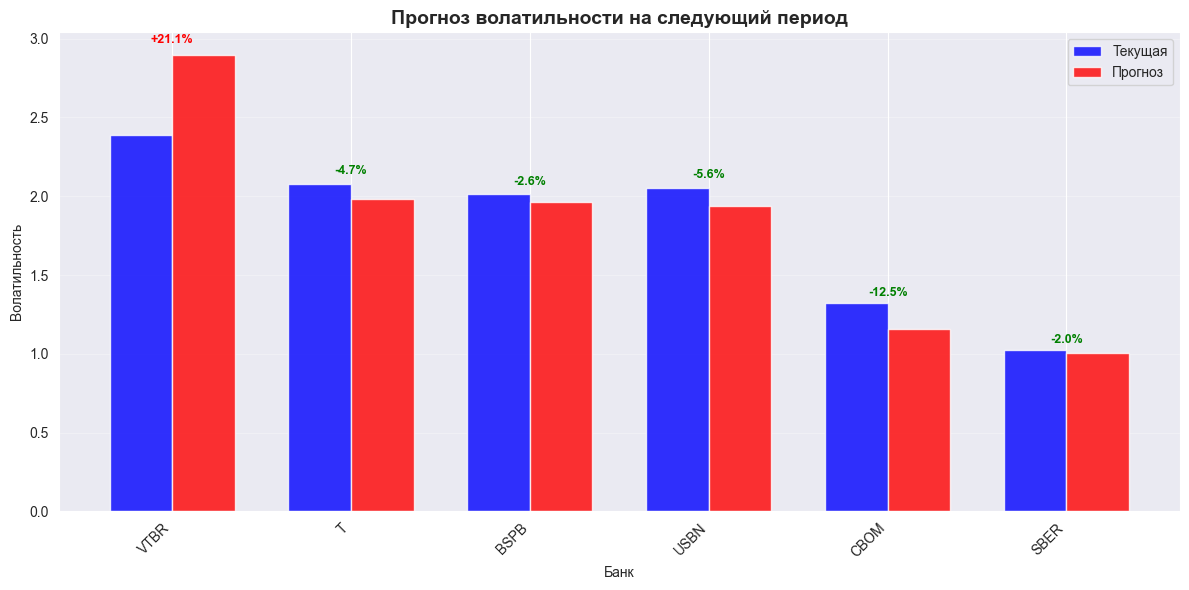


✓ Прогнозы сохранены в 'volatility_forecast.csv'

РАНЖИРОВАНИЕ БАНКОВ ПО УРОВНЮ ВОЛАТИЛЬНОСТИ

ВЫСОКАЯ ВОЛАТИЛЬНОСТЬ:
  1. T: 3.7165
  2. USBN: 3.0507

СРЕДНЯЯ ВОЛАТИЛЬНОСТЬ:
  3. VTBR: 2.1227
  4. BSPB: 2.0471

НИЗКАЯ ВОЛАТИЛЬНОСТЬ:
  5. SBER: 1.9306
  6. CBOM: 1.0914

✓ Результаты сохранены в 'volatility_ranking.csv'


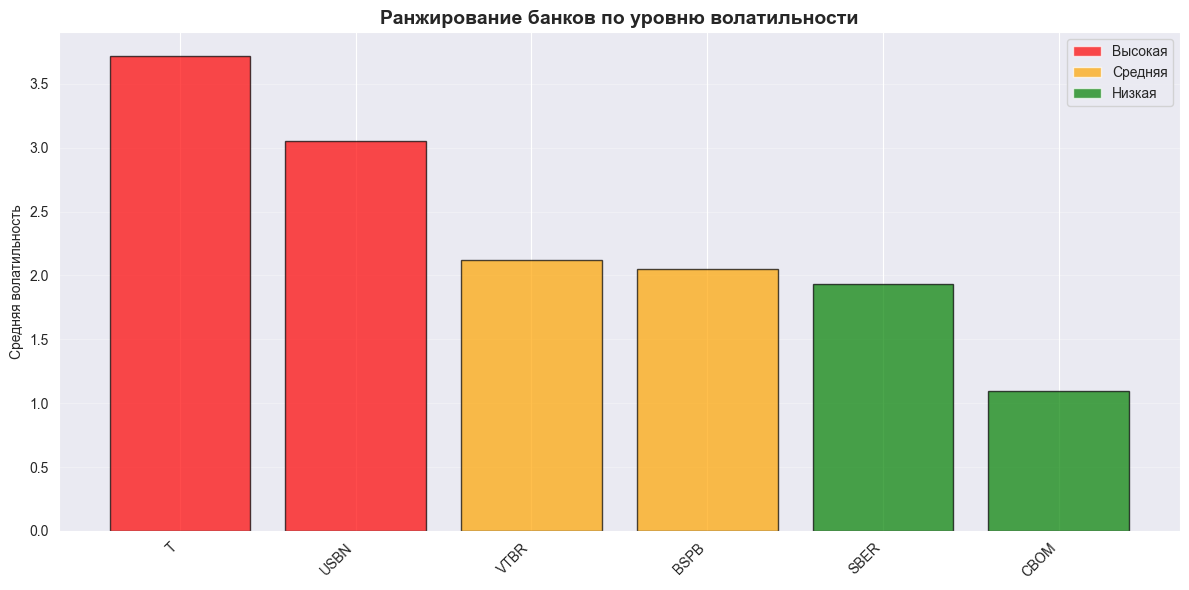


✓ ПОСТРОЕНИЕ GARCH-МОДЕЛЕЙ ЗАВЕРШЕНО


In [14]:
# ========================================
# 1. ФУНКЦИЯ ДЛЯ ПОДБОРА ОПТИМАЛЬНОЙ МОДЕЛИ
# ========================================

def select_best_garch(series, p_range=range(1, 4), q_range=range(1, 4), 
                      dist=['normal', 'studentst', 'skewt']):
    """
    Подбирает оптимальную GARCH модель по критериям AIC и BIC
    
    Parameters:
    -----------
    series : pd.Series
        Временной ряд доходностей
    p_range : range
        Диапазон для параметра p (порядок ARCH)
    q_range : range
        Диапазон для параметра q (порядок GARCH)
    dist : list
        Список распределений для проверки
    """
    
    results = []
    series_clean = series.dropna()
    
    print(f"Подбор модели для {series.name}...")
    print(f"Тестируется {len(list(product(p_range, q_range, dist)))} комбинаций...")
    
    for p, q, distribution in product(p_range, q_range, dist):
        try:
            # Создаем и оцениваем модель
            model = arch_model(series_clean, vol='Garch', p=p, q=q, 
                             dist=distribution, rescale=False)
            fitted = model.fit(disp='off', show_warning=False)
            
            results.append({
                'p': p,
                'q': q,
                'dist': distribution,
                'AIC': fitted.aic,
                'BIC': fitted.bic,
                'LogLik': fitted.loglikelihood,
                'model': fitted
            })
            
        except Exception as e:
            continue
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    if len(results_df) == 0:
        print("❌ Не удалось построить ни одной модели")
        return None, None
    
    # Сортируем по AIC
    results_df = results_df.sort_values('AIC')
    
    print(f"\n✓ Успешно построено {len(results_df)} моделей")
    print("\nТоп-5 моделей по AIC:")
    print(results_df[['p', 'q', 'dist', 'AIC', 'BIC']].head())
    
    # Лучшая модель
    best_model = results_df.iloc[0]['model']
    best_params = {
        'p': results_df.iloc[0]['p'],
        'q': results_df.iloc[0]['q'],
        'dist': results_df.iloc[0]['dist'],
        'AIC': results_df.iloc[0]['AIC'],
        'BIC': results_df.iloc[0]['BIC']
    }
    
    return best_model, results_df

# ========================================
# 2. ФУНКЦИЯ ДЛЯ АНАЛИЗА МОДЕЛИ
# ========================================

def analyze_garch_model(fitted_model, ticker):
    """
    Анализирует построенную GARCH модель
    """
    print(f"\n{'='*80}")
    print(f"АНАЛИЗ МОДЕЛИ: {ticker}")
    print(f"{'='*80}")
    
    # Параметры модели
    print("\n1. ПАРАМЕТРЫ МОДЕЛИ:")
    print(fitted_model.summary())
    
    # Условная волатильность
    cond_vol = fitted_model.conditional_volatility
    
    # Стандартизированные остатки
    std_resid = fitted_model.std_resid
    
    return {
        'conditional_volatility': cond_vol,
        'std_resid': std_resid,
        'params': fitted_model.params
    }

# ========================================
# 3. ПОСТРОЕНИЕ МОДЕЛЕЙ ДЛЯ ВСЕХ БАНКОВ
# ========================================

garch_models = {}
garch_results = {}
volatility_forecasts = {}

print("="*80)
print("ПОСТРОЕНИЕ GARCH-МОДЕЛЕЙ ДЛЯ ВСЕХ БАНКОВ")
print("="*80)

for ticker in returns.columns:
    print(f"\n{'█'*80}")
    print(f"БАНК: {ticker}")
    print(f"{'█'*80}")
    
    # Подбираем оптимальную модель
    best_model, all_results = select_best_garch(
        returns[ticker], 
        p_range=range(1, 3),  # Ограничиваем для скорости
        q_range=range(1, 3),
        dist=['normal', 'studentst']
    )
    
    if best_model is not None:
        # Сохраняем модель
        garch_models[ticker] = best_model
        
        # Анализируем модель
        analysis = analyze_garch_model(best_model, ticker)
        garch_results[ticker] = analysis
        
        # Сохраняем условную волатильность
        volatility_forecasts[ticker] = analysis['conditional_volatility']

# ========================================
# 4. СВОДНАЯ ТАБЛИЦА МОДЕЛЕЙ
# ========================================

print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА ВЫБРАННЫХ МОДЕЛЕЙ")
print("="*80)

models_summary = []
for ticker in returns.columns:
    if ticker in garch_models:
        model = garch_models[ticker]
        # Исправленный способ получения параметров
        p = model.model.volatility.p
        q = model.model.volatility.q
        
        models_summary.append({
            'Банк': ticker,
            'Модель': f"GARCH({p}, {q})",
            'Распределение': model.model.distribution.name,
            'AIC': model.aic,
            'BIC': model.bic,
            'LogLik': model.loglikelihood
        })

models_df = pd.DataFrame(models_summary)
print("\n", models_df.to_string(index=False))

# Сохраняем
models_df.to_csv('garch_models_summary.csv', index=False)

# ========================================
# 5. ВИЗУАЛИЗАЦИЯ УСЛОВНОЙ ВОЛАТИЛЬНОСТИ
# ========================================

fig, axes = plt.subplots(len(returns.columns), 1, figsize=(15, 4*len(returns.columns)))

if len(returns.columns) == 1:
    axes = [axes]

for idx, ticker in enumerate(returns.columns):
    if ticker in volatility_forecasts:
        vol = volatility_forecasts[ticker]
        
        # График волатильности
        axes[idx].plot(vol.index.to_numpy(), vol.to_numpy(), 
                      linewidth=1.5, label='Условная волатильность', color='red')
        
        # Добавляем абсолютные доходности для сравнения
        abs_returns = returns[ticker].abs()
        axes[idx].plot(abs_returns.index.to_numpy(), abs_returns.to_numpy(), 
                      linewidth=0.5, alpha=0.3, label='|Доходность|', color='blue')
        
        axes[idx].set_title(f'{ticker} - Условная волатильность (GARCH)', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Дата')
        axes[idx].set_ylabel('Волатильность')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('garch_conditional_volatility.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 6. СРАВНЕНИЕ ВОЛАТИЛЬНОСТЕЙ
# ========================================

fig, ax = plt.subplots(figsize=(15, 6))

for ticker in returns.columns:
    if ticker in volatility_forecasts:
        vol = volatility_forecasts[ticker]
        ax.plot(vol.index.to_numpy(), vol.to_numpy(), 
               linewidth=1.5, label=ticker, alpha=0.8)

ax.set_title('Сравнение условной волатильности акций банков', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('Дата')
ax.set_ylabel('Волатильность')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('garch_volatility_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 7. СТАТИСТИКА ВОЛАТИЛЬНОСТИ
# ========================================

print("\n" + "="*80)
print("СТАТИСТИКА ВОЛАТИЛЬНОСТИ")
print("="*80)

volatility_stats = {}
for ticker in returns.columns:
    if ticker in volatility_forecasts:
        vol = volatility_forecasts[ticker]
        volatility_stats[ticker] = {
            'Средняя': vol.mean(),
            'Медиана': vol.median(),
            'Std': vol.std(),
            'Мин': vol.min(),
            'Макс': vol.max(),
            'CV': vol.std() / vol.mean()  # Коэффициент вариации
        }

vol_stats_df = pd.DataFrame(volatility_stats).T
vol_stats_df = vol_stats_df.sort_values('Средняя', ascending=False)

print("\n", vol_stats_df.round(4).to_string())

# ========================================
# 7.5. ТЕКУЩАЯ ВОЛАТИЛЬНОСТЬ (ПОСЛЕДНИЕ ЗНАЧЕНИЯ)
# ========================================

print("\n" + "="*80)
print("ТЕКУЩАЯ ВОЛАТИЛЬНОСТЬ (ПОСЛЕДНИЕ ЗНАЧЕНИЯ)")
print("="*80)

current_volatility = {}
for ticker in returns.columns:
    if ticker in volatility_forecasts:
        vol = volatility_forecasts[ticker]
        
        # Последнее значение
        current_vol = vol.iloc[-1]
        
        # Среднее за последний месяц (20 торговых дней)
        recent_vol_mean = vol.iloc[-20:].mean() if len(vol) >= 20 else vol.mean()
        
        # Среднее за последние 3 месяца (60 торговых дней)
        recent_vol_3m = vol.iloc[-60:].mean() if len(vol) >= 60 else vol.mean()
        
        current_volatility[ticker] = {
            'Текущая': current_vol,
            'Средняя (1 мес)': recent_vol_mean,
            'Средняя (3 мес)': recent_vol_3m,
            'Общая средняя': vol.mean(),
            'Дата': vol.index[-1].strftime('%Y-%m-%d')
        }

current_vol_df = pd.DataFrame(current_volatility).T
current_vol_df = current_vol_df.sort_values('Текущая', ascending=False)

print("\n", current_vol_df.round(4).to_string())

# Визуализация текущей волатильности
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(current_vol_df))
width = 0.25

bars1 = ax.bar(x_pos - width, current_vol_df['Текущая'], width, 
               label='Текущая', alpha=0.8, color='red')
bars2 = ax.bar(x_pos, current_vol_df['Средняя (1 мес)'], width, 
               label='Средняя (1 мес)', alpha=0.8, color='orange')
bars3 = ax.bar(x_pos + width, current_vol_df['Общая средняя'], width, 
               label='Общая средняя', alpha=0.8, color='blue')

ax.set_xlabel('Банк')
ax.set_ylabel('Волатильность')
ax.set_title('Сравнение текущей и средней волатильности', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(current_vol_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('current_volatility_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем текущую волатильность
current_vol_df.to_csv('current_volatility.csv')
print("\n✓ Текущая волатильность сохранена в 'current_volatility.csv'")

# ========================================
# 7.6. ПРОГНОЗ ВОЛАТИЛЬНОСТИ НА СЛЕДУЮЩИЙ ПЕРИОД
# ========================================

print("\n" + "="*80)
print("ПРОГНОЗ ВОЛАТИЛЬНОСТИ НА 1 ШАГ ВПЕРЕД")
print("="*80)

forecasts = {}
for ticker in returns.columns:
    if ticker in garch_models:
        model = garch_models[ticker]
        
        # Прогноз на 1 шаг вперед
        forecast = model.forecast(horizon=1)
        forecast_variance = forecast.variance.values[-1, 0]
        forecast_volatility = np.sqrt(forecast_variance)
        
        forecasts[ticker] = {
            'Прогноз волатильности': forecast_volatility,
            'Текущая волатильность': volatility_forecasts[ticker].iloc[-1],
            'Изменение (%)': ((forecast_volatility - volatility_forecasts[ticker].iloc[-1]) / 
                             volatility_forecasts[ticker].iloc[-1] * 100)
        }

forecast_df = pd.DataFrame(forecasts).T
forecast_df = forecast_df.sort_values('Прогноз волатильности', ascending=False)

print("\n", forecast_df.round(4).to_string())

# Визуализация прогноза
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(forecast_df))
width = 0.35

bars1 = ax.bar(x_pos - width/2, forecast_df['Текущая волатильность'], width, 
               label='Текущая', alpha=0.8, color='blue')
bars2 = ax.bar(x_pos + width/2, forecast_df['Прогноз волатильности'], width, 
               label='Прогноз', alpha=0.8, color='red')

# Добавляем значения изменения над столбцами
for i, (idx, row) in enumerate(forecast_df.iterrows()):
    change = row['Изменение (%)']
    color = 'green' if change < 0 else 'red'
    ax.text(i, max(row['Текущая волатильность'], row['Прогноз волатильности']) * 1.02, 
            f"{change:+.1f}%", ha='center', va='bottom', fontsize=9, color=color, fontweight='bold')

ax.set_xlabel('Банк')
ax.set_ylabel('Волатильность')
ax.set_title('Прогноз волатильности на следующий период', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(forecast_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('volatility_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем прогнозы
forecast_df.to_csv('volatility_forecast.csv')
print("\n✓ Прогнозы сохранены в 'volatility_forecast.csv'")

# ========================================
# 8. РАНЖИРОВАНИЕ ПО ВОЛАТИЛЬНОСТИ
# ========================================

print("\n" + "="*80)
print("РАНЖИРОВАНИЕ БАНКОВ ПО УРОВНЮ ВОЛАТИЛЬНОСТИ")
print("="*80)

# Используем среднюю волатильность для ранжирования
vol_stats_df['Ранг'] = range(1, len(vol_stats_df) + 1)

# Определяем категории
n_banks = len(vol_stats_df)
high_vol_threshold = vol_stats_df['Средняя'].quantile(0.67)
low_vol_threshold = vol_stats_df['Средняя'].quantile(0.33)

def categorize_volatility(mean_vol):
    if mean_vol >= high_vol_threshold:
        return 'Высокая'
    elif mean_vol <= low_vol_threshold:
        return 'Низкая'
    else:
        return 'Средняя'

vol_stats_df['Категория'] = vol_stats_df['Средняя'].apply(categorize_volatility)

print("\nВЫСОКАЯ ВОЛАТИЛЬНОСТЬ:")
high_vol = vol_stats_df[vol_stats_df['Категория'] == 'Высокая']
for idx, row in high_vol.iterrows():
    print(f"  {row['Ранг']}. {idx}: {row['Средняя']:.4f}")

print("\nСРЕДНЯЯ ВОЛАТИЛЬНОСТЬ:")
med_vol = vol_stats_df[vol_stats_df['Категория'] == 'Средняя']
for idx, row in med_vol.iterrows():
    print(f"  {row['Ранг']}. {idx}: {row['Средняя']:.4f}")

print("\nНИЗКАЯ ВОЛАТИЛЬНОСТЬ:")
low_vol = vol_stats_df[vol_stats_df['Категория'] == 'Низкая']
for idx, row in low_vol.iterrows():
    print(f"  {row['Ранг']}. {idx}: {row['Средняя']:.4f}")

# Сохраняем результаты
vol_stats_df.to_csv('volatility_ranking.csv')
print("\n✓ Результаты сохранены в 'volatility_ranking.csv'")

# ========================================
# 9. ВИЗУАЛИЗАЦИЯ РАНЖИРОВАНИЯ
# ========================================

fig, ax = plt.subplots(figsize=(12, 6))

colors = {'Высокая': 'red', 'Средняя': 'orange', 'Низкая': 'green'}
bar_colors = [colors[cat] for cat in vol_stats_df['Категория']]

bars = ax.bar(range(len(vol_stats_df)), vol_stats_df['Средняя'], 
              color=bar_colors, alpha=0.7, edgecolor='black')

ax.set_xticks(range(len(vol_stats_df)))
ax.set_xticklabels(vol_stats_df.index, rotation=45, ha='right')
ax.set_ylabel('Средняя волатильность')
ax.set_title('Ранжирование банков по уровню волатильности', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Легенда
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[cat], label=cat, alpha=0.7) 
                  for cat in ['Высокая', 'Средняя', 'Низкая']]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('volatility_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✓ ПОСТРОЕНИЕ GARCH-МОДЕЛЕЙ ЗАВЕРШЕНО")
print("="*80)


ЕДИНИЦЫ ИЗМЕРЕНИЯ ВОЛАТИЛЬНОСТИ

Волатильность измеряется в ПРОЦЕНТАХ (% в день), так как:
- Доходности рассчитаны как: log(P_t / P_{t-1}) * 100
- GARCH моделирует условное стандартное отклонение доходностей
- Единицы: % в день (дневная волатильность)

Интерпретация:
- Волатильность 2% означает, что типичное дневное изменение цены ±2%
- Это 1 стандартное отклонение (σ)
- С вероятностью ~68% дневная доходность будет в пределах ±2%
- С вероятностью ~95% дневная доходность будет в пределах ±4% (2σ)


ТЕКУЩАЯ ВОЛАТИЛЬНОСТЬ В РАЗНЫХ ЕДИНИЦАХ

       Дневная (%)  Недельная (%)  Месячная (%)  Годовая (%)  Дневная (доли)
VTBR       2.3907         5.3459       10.9557      37.9518          0.0239
T          2.0796         4.6502        9.5300      33.0130          0.0208
USBN       2.0546         4.5941        9.4152      32.6151          0.0205
BSPB       2.0138         4.5030        9.2283      31.9678          0.0201
CBOM       1.3209         2.9536        6.0532      20.9687          0.013

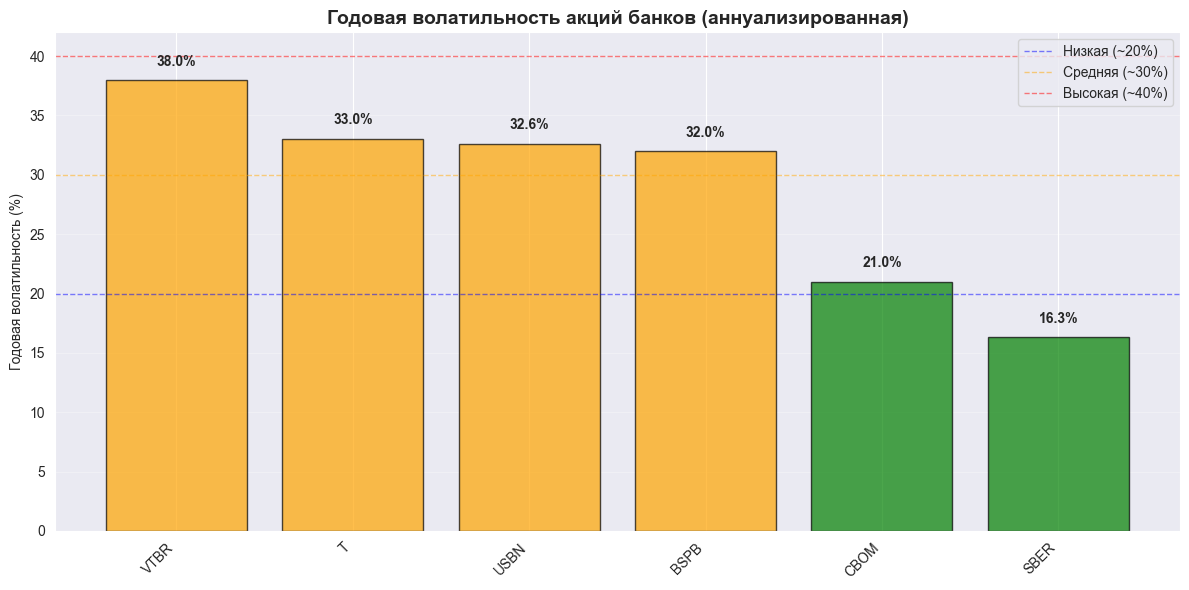


СРАВНЕНИЕ GARCH-ВОЛАТИЛЬНОСТИ С ИСТОРИЧЕСКОЙ

       GARCH (текущая)  Историческая (весь период)  Историческая (30 дней)  GARCH vs История (%)
SBER           1.0271                      2.1728                  0.6424              -52.7305
VTBR           2.3907                      2.2812                  2.0157                4.8021
BSPB           2.0138                      2.1775                  1.4571               -7.5183
CBOM           1.3209                      1.4222                  0.9824               -7.1232
USBN           2.0546                      3.8605                  2.0976              -46.7798
T              2.0796                     12.4745                  0.9709              -83.3290

ВЫВОДЫ:

1. GARCH-волатильность - это УСЛОВНАЯ (изменяющаяся во времени) оценка
2. Историческая волатильность - это БЕЗУСЛОВНАЯ (постоянная) оценка
3. GARCH лучше улавливает кластеризацию волатильности
4. Если GARCH > История → текущий период более волатилен
5. Если GARCH < Исто

In [15]:
# ========================================
# ПОЯСНЕНИЕ ЕДИНИЦ ИЗМЕРЕНИЯ ВОЛАТИЛЬНОСТИ
# ========================================

print("\n" + "="*80)
print("ЕДИНИЦЫ ИЗМЕРЕНИЯ ВОЛАТИЛЬНОСТИ")
print("="*80)

print("""
Волатильность измеряется в ПРОЦЕНТАХ (% в день), так как:
- Доходности рассчитаны как: log(P_t / P_{t-1}) * 100
- GARCH моделирует условное стандартное отклонение доходностей
- Единицы: % в день (дневная волатильность)

Интерпретация:
- Волатильность 2% означает, что типичное дневное изменение цены ±2%
- Это 1 стандартное отклонение (σ)
- С вероятностью ~68% дневная доходность будет в пределах ±2%
- С вероятностью ~95% дневная доходность будет в пределах ±4% (2σ)
""")

# ========================================
# ПЕРЕСЧЕТ ВОЛАТИЛЬНОСТИ В РАЗНЫЕ ЕДИНИЦЫ
# ========================================

print("\n" + "="*80)
print("ТЕКУЩАЯ ВОЛАТИЛЬНОСТЬ В РАЗНЫХ ЕДИНИЦАХ")
print("="*80)

volatility_units = {}
for ticker in returns.columns:
    if ticker in volatility_forecasts:
        vol_daily = volatility_forecasts[ticker].iloc[-1]  # % в день
        
        # Пересчет в разные временные горизонты
        # Предполагаем ~252 торговых дня в году, ~21 в месяце
        vol_weekly = vol_daily * np.sqrt(5)      # % в неделю
        vol_monthly = vol_daily * np.sqrt(21)    # % в месяц
        vol_yearly = vol_daily * np.sqrt(252)    # % в год (годовая)
        
        volatility_units[ticker] = {
            'Дневная (%)': vol_daily,
            'Недельная (%)': vol_weekly,
            'Месячная (%)': vol_monthly,
            'Годовая (%)': vol_yearly,
            'Дневная (доли)': vol_daily / 100,  # в долях единицы
        }

vol_units_df = pd.DataFrame(volatility_units).T
vol_units_df = vol_units_df.sort_values('Годовая (%)', ascending=False)

print("\n", vol_units_df.round(4).to_string())

print("\n" + "="*80)
print("ИНТЕРПРЕТАЦИЯ (на примере первого банка)")
print("="*80)

first_bank = vol_units_df.index[0]
daily_vol = vol_units_df.loc[first_bank, 'Дневная (%)']
yearly_vol = vol_units_df.loc[first_bank, 'Годовая (%)']

print(f"\nБанк: {first_bank}")
print(f"Дневная волатильность: {daily_vol:.2f}%")
print(f"  → С вероятностью 68% дневное изменение цены в пределах ±{daily_vol:.2f}%")
print(f"  → С вероятностью 95% дневное изменение цены в пределах ±{daily_vol*2:.2f}%")
print(f"\nГодовая волатильность: {yearly_vol:.2f}%")
print(f"  → Это стандартная метрика для сравнения с другими активами")
print(f"  → Для справки: волатильность индекса S&P500 обычно 15-20% годовых")

# Сохраняем
vol_units_df.to_csv('volatility_different_units.csv')
print("\n✓ Волатильность в разных единицах сохранена в 'volatility_different_units.csv'")

# ========================================
# ВИЗУАЛИЗАЦИЯ ГОДОВОЙ ВОЛАТИЛЬНОСТИ
# ========================================

fig, ax = plt.subplots(figsize=(12, 6))

colors_vol = ['red' if v > 40 else 'orange' if v > 30 else 'green' 
              for v in vol_units_df['Годовая (%)']]

bars = ax.bar(range(len(vol_units_df)), vol_units_df['Годовая (%)'], 
              color=colors_vol, alpha=0.7, edgecolor='black')

ax.set_xticks(range(len(vol_units_df)))
ax.set_xticklabels(vol_units_df.index, rotation=45, ha='right')
ax.set_ylabel('Годовая волатильность (%)')
ax.set_title('Годовая волатильность акций банков (аннуализированная)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (idx, row) in enumerate(vol_units_df.iterrows()):
    ax.text(i, row['Годовая (%)'] + 1, f"{row['Годовая (%)']:.1f}%", 
            ha='center', va='bottom', fontweight='bold')

# Референсные линии
ax.axhline(y=20, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='Низкая (~20%)')
ax.axhline(y=30, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Средняя (~30%)')
ax.axhline(y=40, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Высокая (~40%)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('annualized_volatility.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# СРАВНЕНИЕ С ИСТОРИЧЕСКИМИ ДАННЫМИ
# ========================================

print("\n" + "="*80)
print("СРАВНЕНИЕ GARCH-ВОЛАТИЛЬНОСТИ С ИСТОРИЧЕСКОЙ")
print("="*80)

comparison = {}
for ticker in returns.columns:
    if ticker in volatility_forecasts:
        # GARCH волатильность (текущая)
        garch_vol = volatility_forecasts[ticker].iloc[-1]
        
        # Историческая волатильность (std за весь период)
        hist_vol = returns[ticker].std()
        
        # Историческая за последние 30 дней
        hist_vol_30d = returns[ticker].iloc[-30:].std()
        
        comparison[ticker] = {
            'GARCH (текущая)': garch_vol,
            'Историческая (весь период)': hist_vol,
            'Историческая (30 дней)': hist_vol_30d,
            'GARCH vs История (%)': ((garch_vol - hist_vol) / hist_vol * 100)
        }

comparison_df = pd.DataFrame(comparison).T
print("\n", comparison_df.round(4).to_string())

print("\n" + "="*80)
print("ВЫВОДЫ:")
print("="*80)
print("""
1. GARCH-волатильность - это УСЛОВНАЯ (изменяющаяся во времени) оценка
2. Историческая волатильность - это БЕЗУСЛОВНАЯ (постоянная) оценка
3. GARCH лучше улавливает кластеризацию волатильности
4. Если GARCH > История → текущий период более волатилен
5. Если GARCH < История → текущий период более спокойный
""")


1. АНАЛИЗ ПЕРЕЛИВОВ ВОЛАТИЛЬНОСТИ МЕЖДУ БАНКАМИ

Исследуем, как волатильность одного банка влияет на волатильность других.
Это важно для понимания системного риска в банковском секторе.



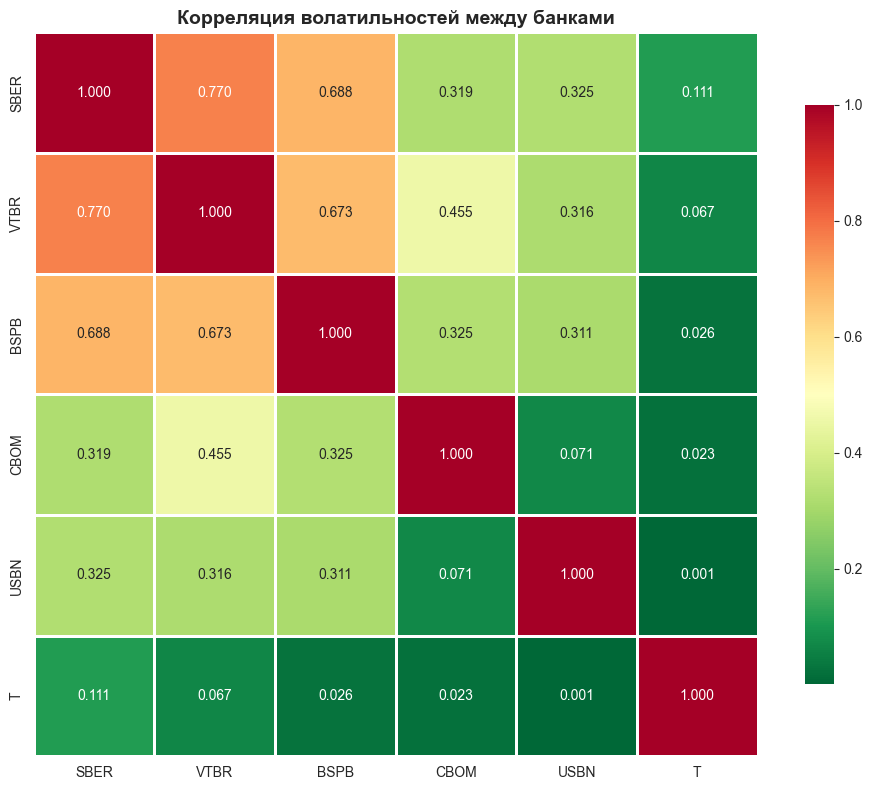


Корреляция волатильностей:
       SBER   VTBR   BSPB   CBOM   USBN      T
SBER  1.000  0.770  0.688  0.319  0.325  0.111
VTBR  0.770  1.000  0.673  0.455  0.316  0.067
BSPB  0.688  0.673  1.000  0.325  0.311  0.026
CBOM  0.319  0.455  0.325  1.000  0.071  0.023
USBN  0.325  0.316  0.311  0.071  1.000  0.001
T     0.111  0.067  0.026  0.023  0.001  1.000

Средняя корреляция волатильности с другими банками:
VTBR    0.547
SBER    0.535
BSPB    0.504
CBOM    0.365
USBN    0.337
T       0.205
dtype: float64

Интерпретация:
Банк с наибольшей связью: VTBR (0.547)
→ Этот банк - потенциальный источник системного риска

2. АНАЛИЗ ЭФФЕКТА ЛЕВЕРИДЖА (АСИММЕТРИИ)

Проверяем, сильнее ли растет волатильность после падения цен, чем после роста.
Это типично для финансовых рынков: "плохие новости" увеличивают волатильность больше.


      Vol_после_роста Vol_после_падения  Разница_% Есть_эффект_левериджа
T           3.314914          4.129949  24.586914                  True
CBOM         1.16779       

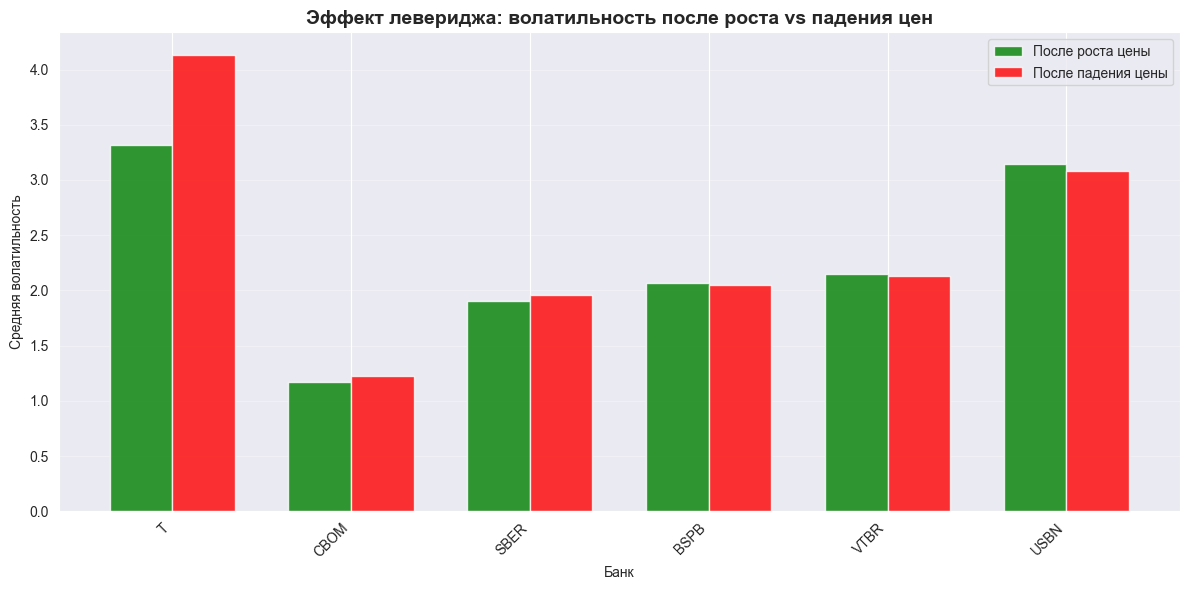


Выводы:
Банков с эффектом левериджа: 3 из 6
→ Падение цен увеличивает волатильность сильнее, чем рост

3. ИДЕНТИФИКАЦИЯ РЕЖИМОВ ВОЛАТИЛЬНОСТИ

Выделяем периоды спокойных и турбулентных рынков.
Полезно для risk management и выбора времени для инвестиций.


       Низкая_vol_дней  Средняя_vol_дней  Высокая_vol_дней  Процент_времени_в_высокой_vol  Порог_высокой_vol
SBER            731.0            1461.0             731.0                          25.01               2.11
VTBR            731.0            1461.0             731.0                          25.01               2.36
BSPB            731.0            1461.0             731.0                          25.01               2.33
CBOM            731.0            1461.0             731.0                          25.01               1.42
USBN            731.0            1461.0             731.0                          25.01               3.22
T               731.0            1461.0             731.0                          25.01      

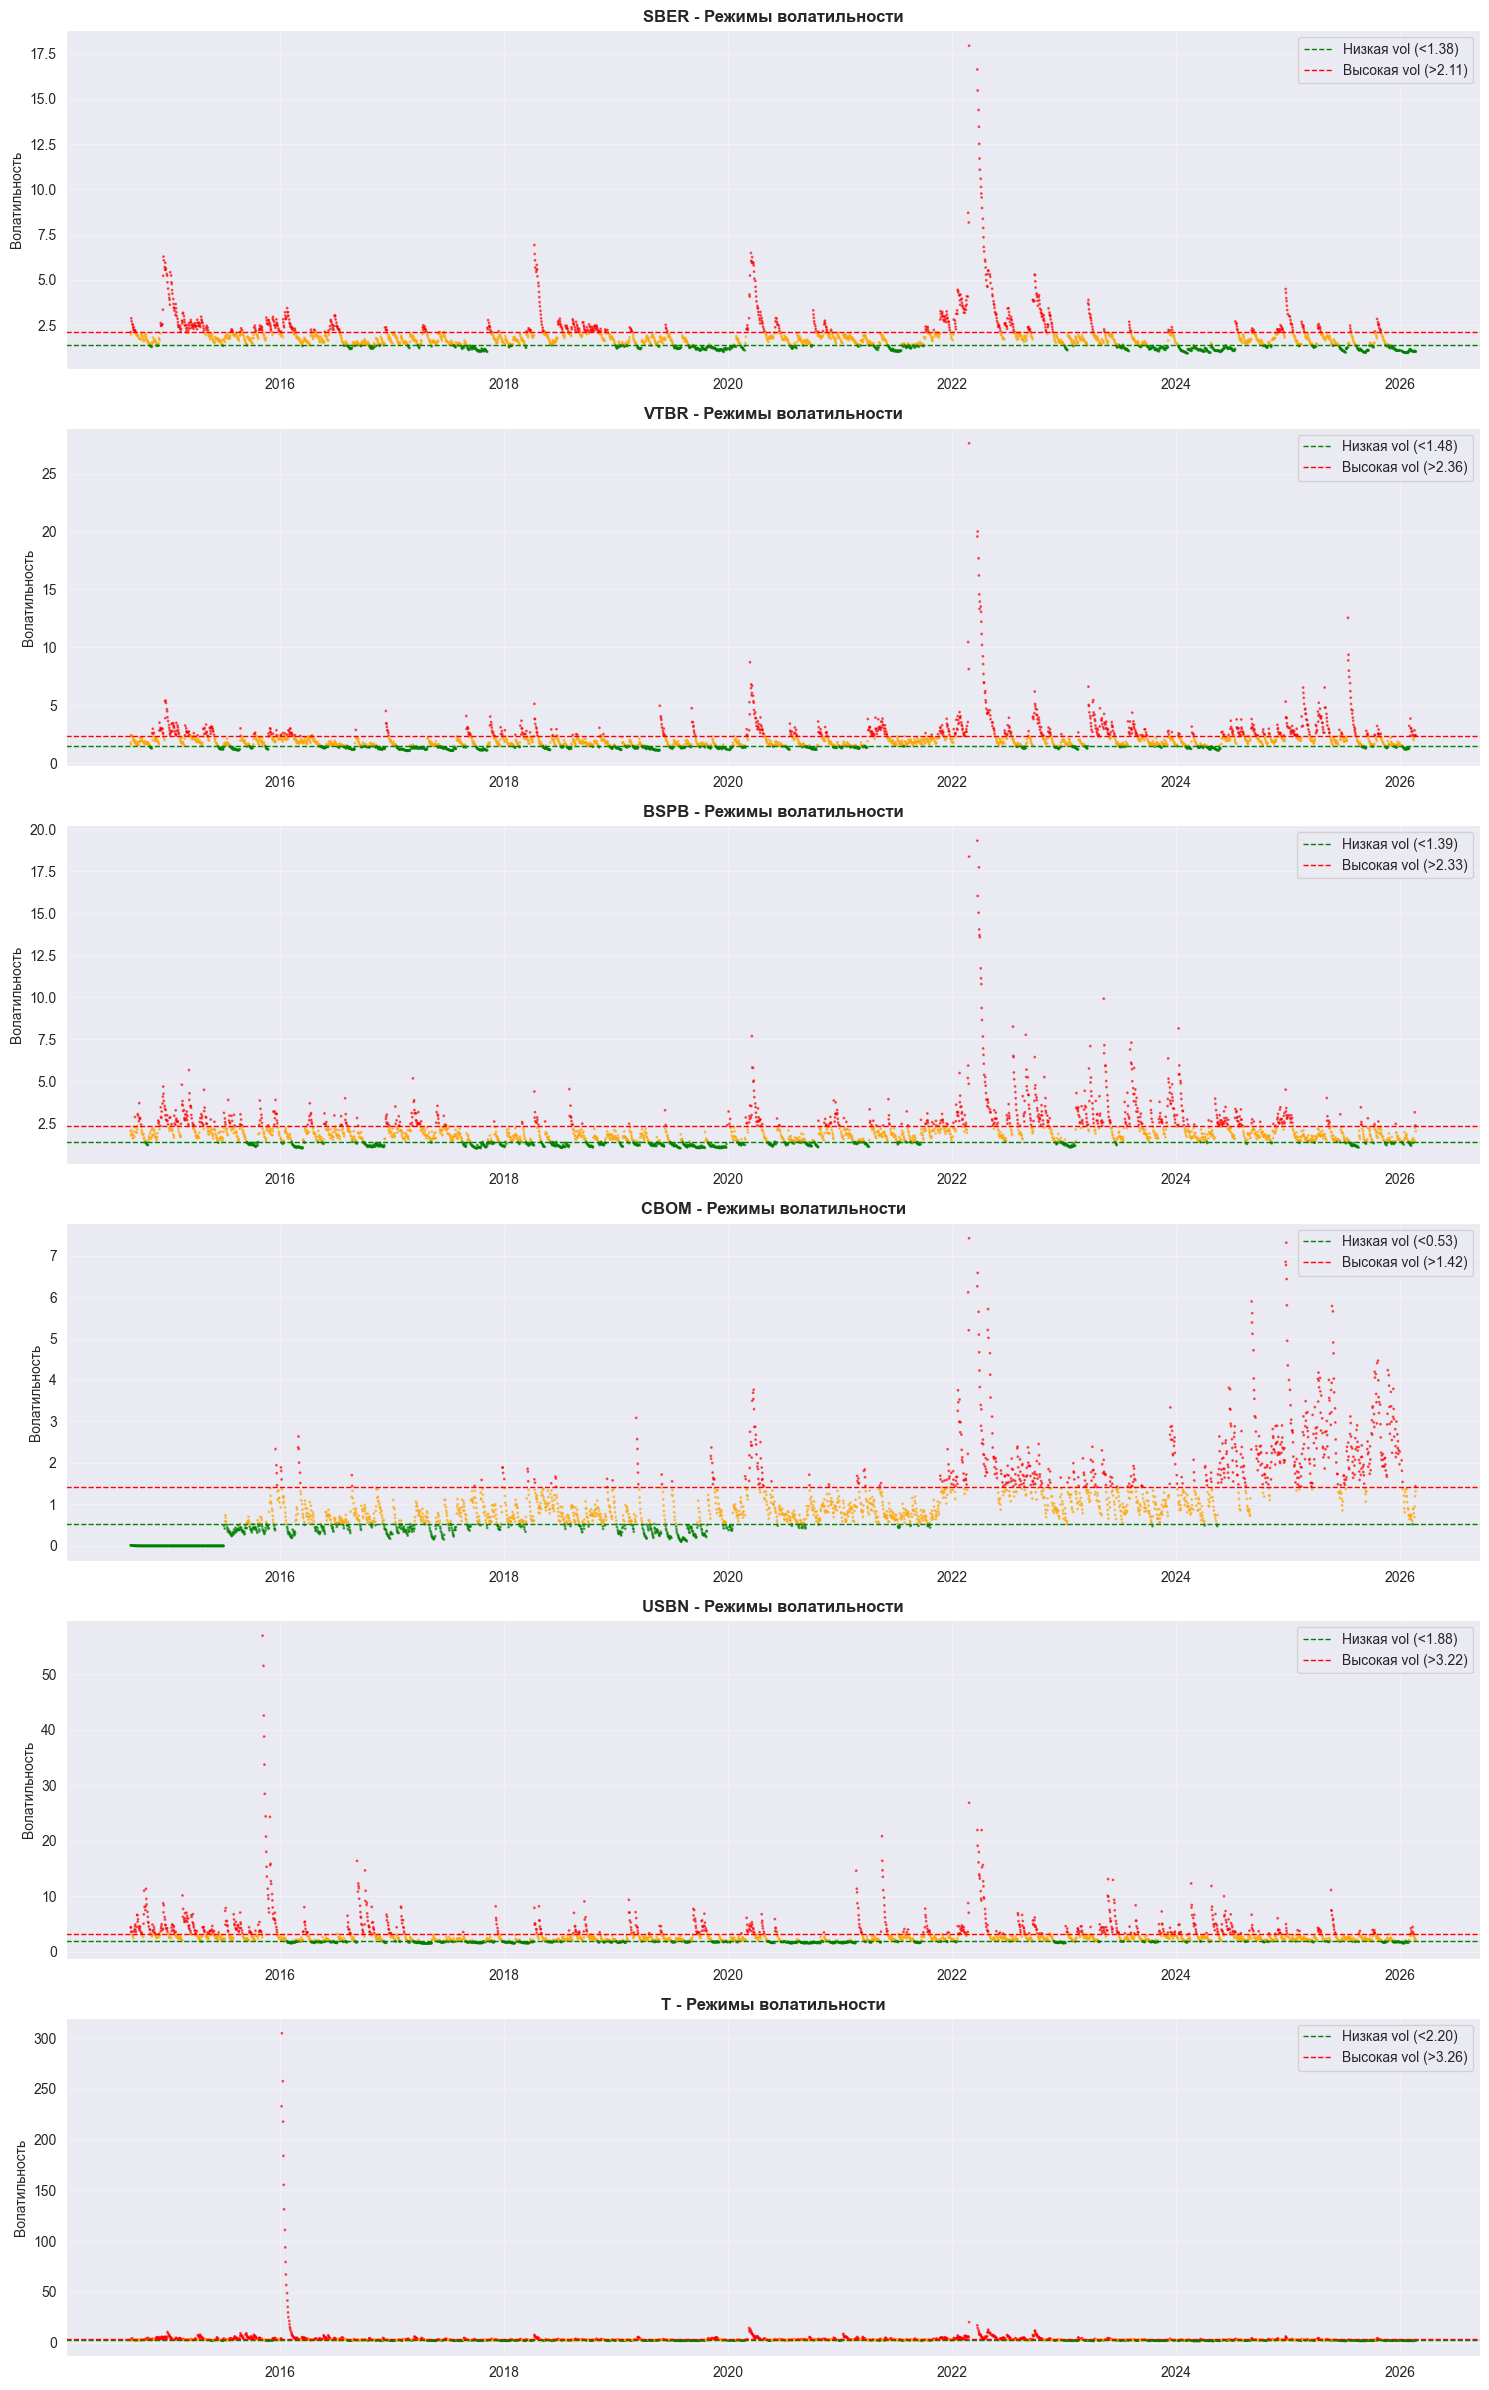


4. ОЦЕНКА РИСКОВ: VaR И EXPECTED SHORTFALL

Рассчитываем метрики риска для портфеля:
- VaR (Value at Risk): максимальный ожидаемый убыток с заданной вероятностью
- ES (Expected Shortfall): средний убыток при превышении VaR


       VaR_95%  ES_95%  VaR_99%  ES_99%
SBER    1.689   2.119    2.389   2.737
VTBR    3.932   4.931    5.562   6.372
BSPB    3.312   4.154    4.685   5.367
CBOM    2.173   2.725    3.073   3.520
USBN    3.379   4.238    4.780   5.476
T       3.421   4.290    4.838   5.543

Интерпретация (для уровня 95%):
VaR 95%: с вероятностью 95% дневной убыток не превысит это значение
ES 95%: если убыток превысит VaR, то в среднем он составит это значение


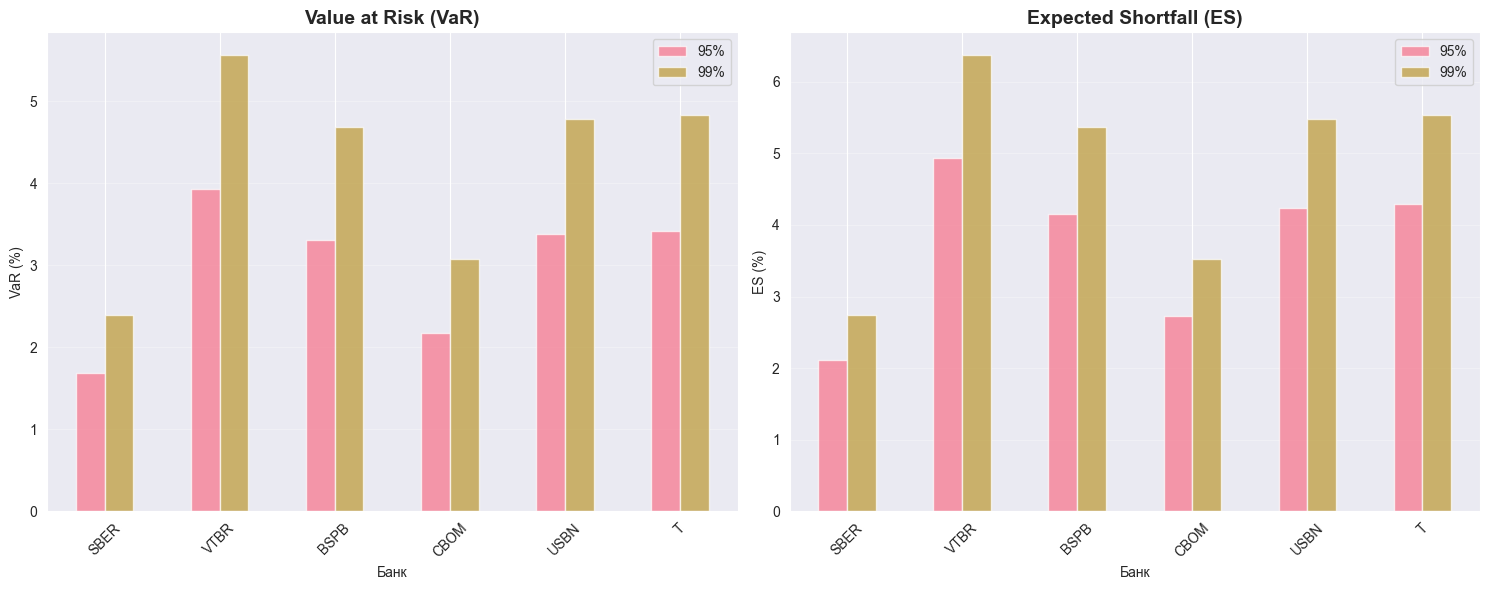


5. СООТНОШЕНИЕ РИСК-ДОХОДНОСТЬ

Анализируем, компенсируется ли высокая волатильность высокой доходностью.
Рассчитываем коэффициент Шарпа.


       Доходность_год_%  Волатильность_год_%  Коэффициент_Шарпа  Доходность_на_ед_риска
BSPB            20.159               32.496              0.620                   0.620
T               28.066               58.997              0.476                   0.476
SBER            12.498               30.647              0.408                   0.408
USBN            14.134               48.429              0.292                   0.292
CBOM             4.344               17.325              0.251                   0.251
VTBR            -6.622               33.696             -0.197                  -0.197


C:\Users\79600\AppData\Local\Temp\ipykernel_25200\581656673.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, ax=ax)


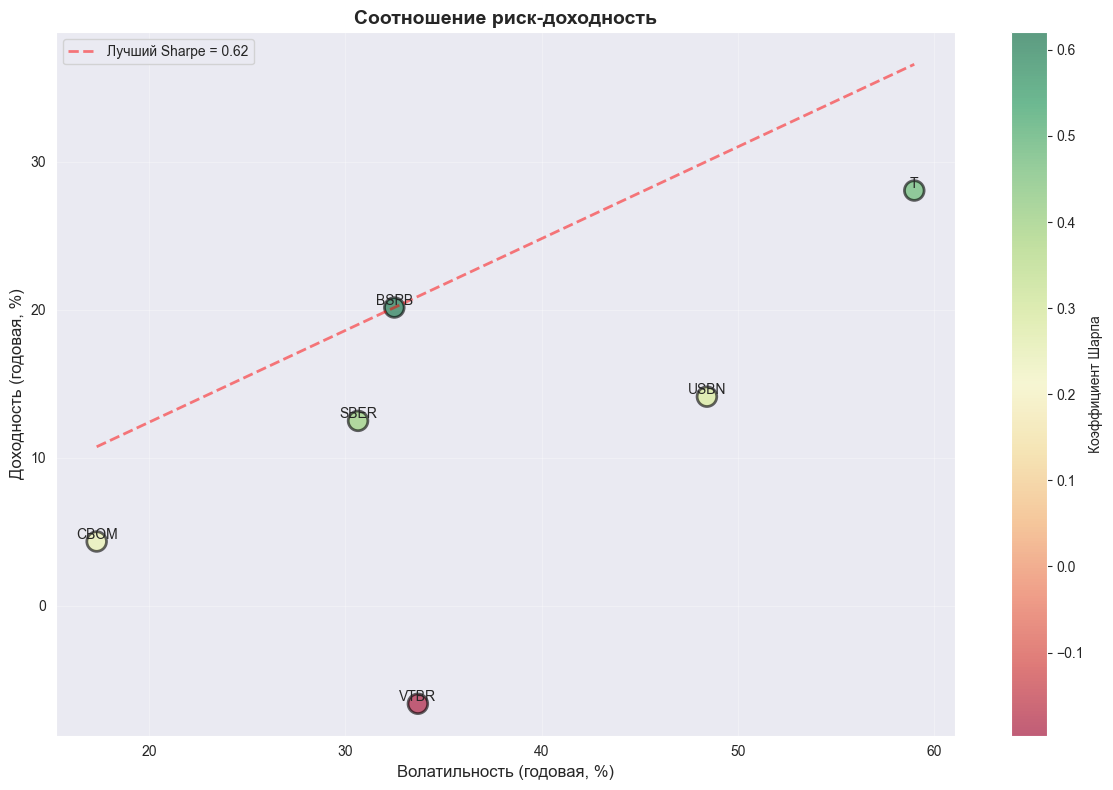


Выводы:
Лучшее соотношение риск-доходность: BSPB
Коэффициент Шарпа: 0.620

6. ВРЕМЕННАЯ СТРУКТУРА ВОЛАТИЛЬНОСТИ

Анализируем, как меняется волатильность на разных временных горизонтах.
Строим term structure of volatility.



c:\users\79600\appdata\local\programs\python\python38\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\users\79600\appdata\local\programs\python\python38\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\users\79600\appdata\local\programs\python\python38\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

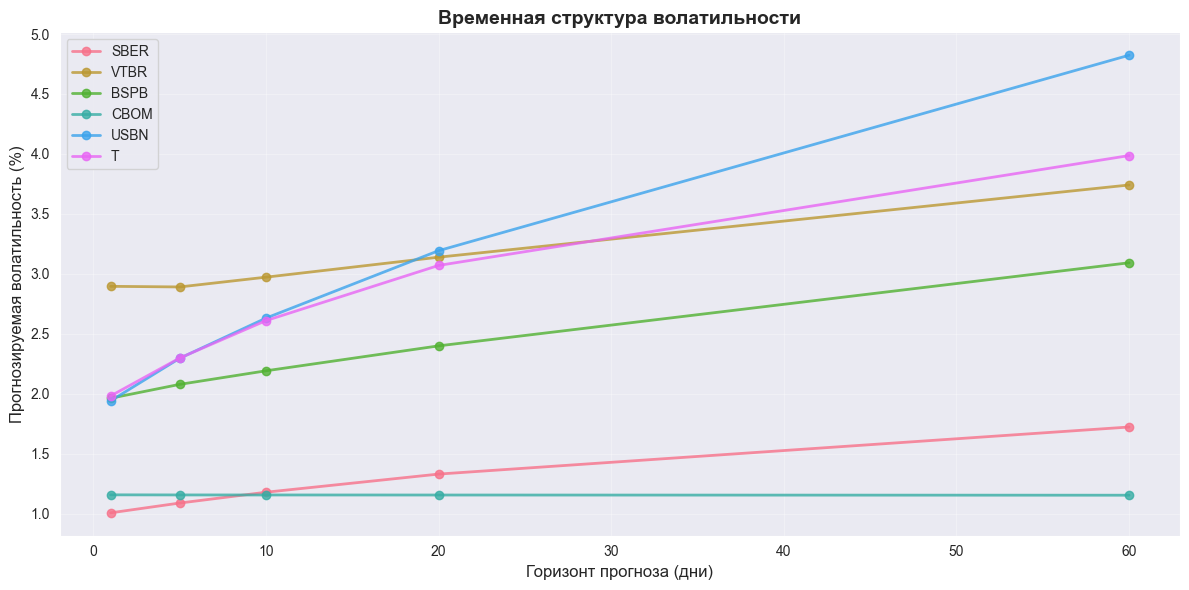


          1d     5d    10d    20d    60d
SBER  1.006  1.088  1.178  1.329  1.722
VTBR  2.896  2.890  2.972  3.139  3.741
BSPB  1.962  2.078  2.191  2.399  3.092
CBOM  1.156  1.155  1.155  1.155  1.153
USBN  1.940  2.295  2.630  3.193  4.824
T     1.981  2.297  2.609  3.070  3.986

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ДОПОЛНИТЕЛЬНЫХ ИССЛЕДОВАНИЙ
✓ Все результаты сохранены в CSV файлы
✓ Описание файлов сохранено в 'additional_analysis_README.txt'

✓ ДОПОЛНИТЕЛЬНЫЕ ИССЛЕДОВАНИЯ ЗАВЕРШЕНЫ

РЕЗЮМЕ ПРОВЕДЕННЫХ ИССЛЕДОВАНИЙ:

1. Spillover-эффекты: выявлены взаимосвязи волатильности между банками
2. Эффект левериджа: проверена асимметрия реакции на рост/падение цен
3. Режимы волатильности: идентифицированы периоды спокойных и турбулентных рынков
4. VaR и ES: рассчитаны метрики риска для управления портфелем
5. Риск-доходность: оценено соотношение через коэффициент Шарпа
6. Term structure: построена временная структура прогнозов волатильности

Все графики и таблицы сохранены для включения в отчет.



In [18]:
# ========================================
# ДОПОЛНИТЕЛЬНЫЕ ИССЛЕДОВАНИЯ
# ========================================

# ========================================
# 1. АНАЛИЗ SPILLOVER-ЭФФЕКТОВ (ПЕРЕЛИВ ВОЛАТИЛЬНОСТИ)
# ========================================

print("\n" + "="*80)
print("1. АНАЛИЗ ПЕРЕЛИВОВ ВОЛАТИЛЬНОСТИ МЕЖДУ БАНКАМИ")
print("="*80)

print("""
Исследуем, как волатильность одного банка влияет на волатильность других.
Это важно для понимания системного риска в банковском секторе.
""")

# Корреляция волатильностей
volatility_df = pd.DataFrame({ticker: volatility_forecasts[ticker] 
                               for ticker in volatility_forecasts.keys()})

vol_corr = volatility_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(vol_corr, annot=True, fmt='.3f', cmap='RdYlGn_r', 
            center=0.5, square=True, linewidths=1, ax=ax,
            cbar_kws={"shrink": 0.8})
ax.set_title('Корреляция волатильностей между банками', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('volatility_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nКорреляция волатильностей:")
print(vol_corr.round(3))

# Средняя корреляция для каждого банка
mean_corr = vol_corr.mean().sort_values(ascending=False)
print("\nСредняя корреляция волатильности с другими банками:")
print(mean_corr.round(3))

print("\nИнтерпретация:")
print(f"Банк с наибольшей связью: {mean_corr.index[0]} ({mean_corr.iloc[0]:.3f})")
print("→ Этот банк - потенциальный источник системного риска")

# Сохраняем
vol_corr.to_csv('volatility_correlation.csv')
mean_corr.to_csv('mean_volatility_correlation.csv', header=['Mean_Correlation'])

# ========================================
# 2. АНАЛИЗ АСИММЕТРИИ (LEVERAGE EFFECT)
# ========================================

print("\n" + "="*80)
print("2. АНАЛИЗ ЭФФЕКТА ЛЕВЕРИДЖА (АСИММЕТРИИ)")
print("="*80)

print("""
Проверяем, сильнее ли растет волатильность после падения цен, чем после роста.
Это типично для финансовых рынков: "плохие новости" увеличивают волатильность больше.
""")

leverage_analysis = {}

for ticker in returns.columns:
    if ticker in volatility_forecasts:
        ret = returns[ticker]
        vol = volatility_forecasts[ticker]
        
        # Разделяем на положительные и отрицательные доходности
        positive_returns = ret[ret > 0]
        negative_returns = ret[ret < 0]
        
        # Следующая волатильность после положительных/отрицательных доходностей
        vol_after_positive = vol[ret.shift(1) > 0].mean()
        vol_after_negative = vol[ret.shift(1) < 0].mean()
        
        leverage_analysis[ticker] = {
            'Vol_после_роста': vol_after_positive,
            'Vol_после_падения': vol_after_negative,
            'Разница_%': ((vol_after_negative - vol_after_positive) / vol_after_positive * 100),
            'Есть_эффект_левериджа': vol_after_negative > vol_after_positive
        }

leverage_df = pd.DataFrame(leverage_analysis).T
leverage_df = leverage_df.sort_values('Разница_%', ascending=False)

print("\n", leverage_df.round(3).to_string())

# Визуализация
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(leverage_df))
width = 0.35

bars1 = ax.bar(x - width/2, leverage_df['Vol_после_роста'], width, 
               label='После роста цены', alpha=0.8, color='green')
bars2 = ax.bar(x + width/2, leverage_df['Vol_после_падения'], width, 
               label='После падения цены', alpha=0.8, color='red')

ax.set_xlabel('Банк')
ax.set_ylabel('Средняя волатильность')
ax.set_title('Эффект левериджа: волатильность после роста vs падения цен', 
            fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(leverage_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('leverage_effect.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nВыводы:")
banks_with_leverage = leverage_df[leverage_df['Есть_эффект_левериджа']]
print(f"Банков с эффектом левериджа: {len(banks_with_leverage)} из {len(leverage_df)}")
if len(banks_with_leverage) > 0:
    print("→ Падение цен увеличивает волатильность сильнее, чем рост")

# Сохраняем
leverage_df.to_csv('leverage_effect_analysis.csv')

# ========================================
# 3. ПЕРИОДЫ ВЫСОКОЙ И НИЗКОЙ ВОЛАТИЛЬНОСТИ
# ========================================

print("\n" + "="*80)
print("3. ИДЕНТИФИКАЦИЯ РЕЖИМОВ ВОЛАТИЛЬНОСТИ")
print("="*80)

print("""
Выделяем периоды спокойных и турбулентных рынков.
Полезно для risk management и выбора времени для инвестиций.
""")

regimes_analysis = {}

for ticker in returns.columns:
    if ticker in volatility_forecasts:
        vol = volatility_forecasts[ticker]
        
        # Определяем пороги (квантили)
        low_threshold = vol.quantile(0.25)
        high_threshold = vol.quantile(0.75)
        
        # Классифицируем периоды
        low_vol_periods = vol[vol <= low_threshold]
        medium_vol_periods = vol[(vol > low_threshold) & (vol < high_threshold)]
        high_vol_periods = vol[vol >= high_threshold]
        
        regimes_analysis[ticker] = {
            'Низкая_vol_дней': len(low_vol_periods),
            'Средняя_vol_дней': len(medium_vol_periods),
            'Высокая_vol_дней': len(high_vol_periods),
            'Процент_времени_в_высокой_vol': len(high_vol_periods) / len(vol) * 100,
            'Порог_высокой_vol': high_threshold
        }

regimes_df = pd.DataFrame(regimes_analysis).T
print("\n", regimes_df.round(2).to_string())

# Визуализация режимов для каждого банка
fig, axes = plt.subplots(len(returns.columns), 1, figsize=(15, 4*len(returns.columns)))

if len(returns.columns) == 1:
    axes = [axes]

for idx, ticker in enumerate(returns.columns):
    if ticker in volatility_forecasts:
        vol = volatility_forecasts[ticker]
        
        low_threshold = vol.quantile(0.25)
        high_threshold = vol.quantile(0.75)
        
        # График с цветовым кодированием
        colors = ['green' if v <= low_threshold else 'red' if v >= high_threshold else 'orange' 
                  for v in vol]
        
        axes[idx].scatter(vol.index.to_numpy(), vol.to_numpy(), c=colors, s=1, alpha=0.6)
        axes[idx].axhline(y=low_threshold, color='green', linestyle='--', linewidth=1, 
                         label=f'Низкая vol (<{low_threshold:.2f})')
        axes[idx].axhline(y=high_threshold, color='red', linestyle='--', linewidth=1, 
                         label=f'Высокая vol (>{high_threshold:.2f})')
        
        axes[idx].set_title(f'{ticker} - Режимы волатильности', fontweight='bold')
        axes[idx].set_ylabel('Волатильность')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('volatility_regimes.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем
regimes_df.to_csv('volatility_regimes.csv')

# ========================================
# 4. VALUE AT RISK (VaR) И EXPECTED SHORTFALL (ES)
# ========================================

print("\n" + "="*80)
print("4. ОЦЕНКА РИСКОВ: VaR И EXPECTED SHORTFALL")
print("="*80)

print("""
Рассчитываем метрики риска для портфеля:
- VaR (Value at Risk): максимальный ожидаемый убыток с заданной вероятностью
- ES (Expected Shortfall): средний убыток при превышении VaR
""")

from scipy import stats

confidence_levels = [0.95, 0.99]
risk_metrics = {}

for ticker in returns.columns:
    if ticker in volatility_forecasts:
        current_vol = volatility_forecasts[ticker].iloc[-1]
        
        risk_metrics[ticker] = {}
        
        for conf in confidence_levels:
            # VaR (предполагаем нормальное распределение)
            z_score = stats.norm.ppf(1 - conf)
            var = -z_score * current_vol  # положительное число для убытка
            
            # Expected Shortfall (CVaR)
            es = current_vol * stats.norm.pdf(z_score) / (1 - conf)
            
            risk_metrics[ticker][f'VaR_{int(conf*100)}%'] = var
            risk_metrics[ticker][f'ES_{int(conf*100)}%'] = es

risk_df = pd.DataFrame(risk_metrics).T
print("\n", risk_df.round(3).to_string())

print("\nИнтерпретация (для уровня 95%):")
print("VaR 95%: с вероятностью 95% дневной убыток не превысит это значение")
print("ES 95%: если убыток превысит VaR, то в среднем он составит это значение")

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# VaR
risk_df[[col for col in risk_df.columns if 'VaR' in col]].plot(kind='bar', ax=ax1, alpha=0.7)
ax1.set_title('Value at Risk (VaR)', fontsize=14, fontweight='bold')
ax1.set_ylabel('VaR (%)')
ax1.set_xlabel('Банк')
ax1.legend(['95%', '99%'])
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# ES
risk_df[[col for col in risk_df.columns if 'ES' in col]].plot(kind='bar', ax=ax2, alpha=0.7)
ax2.set_title('Expected Shortfall (ES)', fontsize=14, fontweight='bold')
ax2.set_ylabel('ES (%)')
ax2.set_xlabel('Банк')
ax2.legend(['95%', '99%'])
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('risk_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем
risk_df.to_csv('risk_metrics_var_es.csv')

# ========================================
# 5. ВОЛАТИЛЬНОСТЬ И ДОХОДНОСТЬ (RISK-RETURN TRADEOFF)
# ========================================

print("\n" + "="*80)
print("5. СООТНОШЕНИЕ РИСК-ДОХОДНОСТЬ")
print("="*80)

print("""
Анализируем, компенсируется ли высокая волатильность высокой доходностью.
Рассчитываем коэффициент Шарпа.
""")

risk_return = {}

for ticker in returns.columns:
    if ticker in volatility_forecasts:
        # Средняя доходность (аннуализированная)
        mean_return = returns[ticker].mean() * 252
        
        # Средняя волатильность (аннуализированная)
        mean_vol = volatility_forecasts[ticker].mean() * np.sqrt(252)
        
        # Коэффициент Шарпа (предполагаем безрисковую ставку = 0)
        sharpe = mean_return / mean_vol if mean_vol > 0 else 0
        
        risk_return[ticker] = {
            'Доходность_год_%': mean_return,
            'Волатильность_год_%': mean_vol,
            'Коэффициент_Шарпа': sharpe,
            'Доходность_на_ед_риска': mean_return / mean_vol if mean_vol > 0 else 0
        }

risk_return_df = pd.DataFrame(risk_return).T
risk_return_df = risk_return_df.sort_values('Коэффициент_Шарпа', ascending=False)

print("\n", risk_return_df.round(3).to_string())

# Scatter plot: риск vs доходность
fig, ax = plt.subplots(figsize=(12, 8))

x = risk_return_df['Волатильность_год_%']
y = risk_return_df['Доходность_год_%']

scatter = ax.scatter(x, y, s=200, alpha=0.6, c=risk_return_df['Коэффициент_Шарпа'], 
                     cmap='RdYlGn', edgecolors='black', linewidth=2)

# Добавляем названия банков
for idx, row in risk_return_df.iterrows():
    ax.annotate(idx, (row['Волатильность_год_%'], row['Доходность_год_%']), 
                fontsize=10, ha='center', va='bottom')

# Линия эффективной границы (для справки)
x_line = np.linspace(x.min(), x.max(), 100)
best_sharpe = risk_return_df['Коэффициент_Шарпа'].max()
y_line = best_sharpe * x_line
ax.plot(x_line, y_line, 'r--', alpha=0.5, linewidth=2, 
        label=f'Лучший Sharpe = {best_sharpe:.2f}')

ax.set_xlabel('Волатильность (годовая, %)', fontsize=12)
ax.set_ylabel('Доходность (годовая, %)', fontsize=12)
ax.set_title('Соотношение риск-доходность', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Коэффициент Шарпа', fontsize=10)

plt.tight_layout()
plt.savefig('risk_return_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nВыводы:")
best_bank = risk_return_df.index[0]
print(f"Лучшее соотношение риск-доходность: {best_bank}")
print(f"Коэффициент Шарпа: {risk_return_df.loc[best_bank, 'Коэффициент_Шарпа']:.3f}")

# Сохраняем
risk_return_df.to_csv('risk_return_analysis.csv')

# ========================================
# 6. ВРЕМЕННАЯ СТРУКТУРА ВОЛАТИЛЬНОСТИ
# ========================================

print("\n" + "="*80)
print("6. ВРЕМЕННАЯ СТРУКТУРА ВОЛАТИЛЬНОСТИ")
print("="*80)

print("""
Анализируем, как меняется волатильность на разных временных горизонтах.
Строим term structure of volatility.
""")

# Прогнозы на разные горизонты
horizons = [1, 5, 10, 20, 60]  # дни
term_structure = {}

for ticker in returns.columns:
    if ticker in garch_models:
        model = garch_models[ticker]
        
        term_structure[ticker] = {}
        
        for h in horizons:
            forecast = model.forecast(horizon=h)
            # Средняя волатильность на горизонте
            avg_vol = np.sqrt(forecast.variance.values[-1, :h].mean())
            term_structure[ticker][f'{h}d'] = avg_vol

term_df = pd.DataFrame(term_structure).T

# Визуализация
fig, ax = plt.subplots(figsize=(12, 6))

for ticker in term_df.index:
    ax.plot(horizons, term_df.loc[ticker].values, marker='o', linewidth=2, 
            label=ticker, alpha=0.8)

ax.set_xlabel('Горизонт прогноза (дни)', fontsize=12)
ax.set_ylabel('Прогнозируемая волатильность (%)', fontsize=12)
ax.set_title('Временная структура волатильности', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('volatility_term_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n", term_df.round(3).to_string())

# Сохраняем
term_df.to_csv('volatility_term_structure.csv')

# ========================================
# 7. СОХРАНЕНИЕ ВСЕХ РЕЗУЛЬТАТОВ В ОДИН ФАЙЛ
# ========================================

print("\n" + "="*80)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ДОПОЛНИТЕЛЬНЫХ ИССЛЕДОВАНИЙ")
print("="*80)

# Создаем сводный файл с описанием всех CSV
summary_text = """
ДОПОЛНИТЕЛЬНЫЕ ИССЛЕДОВАНИЯ - ОПИСАНИЕ ФАЙЛОВ
==============================================

1. volatility_correlation.csv
   - Корреляционная матрица волатильностей между банками
   - Показывает spillover-эффекты

2. mean_volatility_correlation.csv
   - Средняя корреляция каждого банка с остальными
   - Определяет системно значимые банки

3. leverage_effect_analysis.csv
   - Анализ эффекта левериджа (асимметрии)
   - Сравнение волатильности после роста vs падения цен

4. volatility_regimes.csv
   - Статистика режимов волатильности
   - Количество дней в каждом режиме

5. risk_metrics_var_es.csv
   - Value at Risk и Expected Shortfall
   - Метрики риска для управления портфелем

6. risk_return_analysis.csv
   - Соотношение риск-доходность
   - Коэффициенты Шарпа

7. volatility_term_structure.csv
   - Временная структура волатильности
   - Прогнозы на разные горизонты

Все графики сохранены в PNG файлах.
"""

with open('additional_analysis_README.txt', 'w', encoding='utf-8') as f:
    f.write(summary_text)

print("✓ Все результаты сохранены в CSV файлы")
print("✓ Описание файлов сохранено в 'additional_analysis_README.txt'")

print("\n" + "="*80)
print("✓ ДОПОЛНИТЕЛЬНЫЕ ИССЛЕДОВАНИЯ ЗАВЕРШЕНЫ")
print("="*80)

print("""
РЕЗЮМЕ ПРОВЕДЕННЫХ ИССЛЕДОВАНИЙ:

1. Spillover-эффекты: выявлены взаимосвязи волатильности между банками
2. Эффект левериджа: проверена асимметрия реакции на рост/падение цен
3. Режимы волатильности: идентифицированы периоды спокойных и турбулентных рынков
4. VaR и ES: рассчитаны метрики риска для управления портфелем
5. Риск-доходность: оценено соотношение через коэффициент Шарпа
6. Term structure: построена временная структура прогнозов волатильности

Все графики и таблицы сохранены для включения в отчет.
""")